# Hillas parameters calculation

This notebook explores the next step in reconstruction: calculation of the Hillas parameters. The notebook shows what the effect of the new cleaning autoencoders are on the Hillas parameters.

In [1]:
# Importing some libraries

# Torch 
import torch
from torch import nn
import torch.nn.functional as F
from torchview import draw_graph

# Other libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt

# cta-pipe
import ctapipe
from ctapipe.image import dilate, tailcuts_clean, toymodel, hillas
from ctapipe.instrument import SubarrayDescription
from ctapipe.visualization import CameraDisplay

from sklearn.metrics import jaccard_score

**Unpacking the data**

In [2]:
class CPU_Unpickler(pickle.Unpickler):
    # to avoid errors that occur when loading pickle files on cpu that were originally saved using a gpu
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [3]:
# Function that enables you to unpack a certain chunk of data
def load_chunk_file(file_path, chunk_i):
    with open(file_path+f'chunk_{chunk_i}', 'rb') as file:
            loaded_data = CPU_Unpickler(file).load()
            
    return loaded_data

In [4]:
# The locations of the data
file_path_noisy = '/lustre/fs23/group/cta/users/amehta/summer_student_data/noisy_images/'
file_path_true = '/lustre/fs23/group/cta/users/amehta/summer_student_data/true_images/'

# Unpack 100 chunks of data
chunk_tot = 100

data_noisy_tot = np.array([])
data_true_tot = np.array([])

for chunk_i in range(0,chunk_tot):
    data_noisy_all = load_chunk_file(file_path_noisy, chunk_i)
    mask_gamma_ray = np.array((data_noisy_all[1]==1))
    data_noisy_chunk = np.array(data_noisy_all[0])[mask_gamma_ray]
    data_noisy_tot = np.append(data_noisy_tot, data_noisy_chunk)
    
    data_true_all = load_chunk_file(file_path_true, chunk_i)
    data_true_chunk = np.array(data_true_all[0])[mask_gamma_ray]
    data_true_tot = np.append(data_true_tot, data_true_chunk)
    
# Get it in the right shape
data_noisy = data_noisy_tot.reshape(64*chunk_tot, 56, 56)
data_true = data_true_tot.reshape(64*chunk_tot, 56, 56)

In [5]:
# Make a mask of the locations of the nans, so that we can put them back in after fitting.

nan_mask = np.isnan(data_noisy[0])
data_noisy_nonan = np.nan_to_num(data_noisy)

# Look at the sum of all the pixels for the noisy and true images

images_noisy_sum = np.nansum(data_noisy, axis=(1,2))
images_true_sum = np.nansum(data_true, axis=(1,2))

images_high_mask = (images_noisy_sum>60)

# Look at the true images only with pixels of 0 and 1 (non-signal and signal)
# For the purpose of the classification

threshold = 0

data_true_binary = np.zeros((64*chunk_tot, 56, 56))
data_true_binary[data_true>threshold] = 1
data_true_binary_flat = data_true_binary.reshape((64*chunk_tot, 56*56))

# Putting them to the right form with normalization
data_noisy_arr = data_noisy[images_high_mask]
pix_max = np.nanmax(data_noisy_arr, axis=(1,2))[:, np.newaxis, np.newaxis]
pix_min = np.nanmin(data_noisy_arr, axis=(1,2))[:, np.newaxis, np.newaxis]
data_noisy_norm = np.nan_to_num((data_noisy_arr - pix_min)/(pix_max-pix_min))

data_noisy_tensor = (torch.from_numpy(data_noisy_norm).float())
data_noisy_tensor = (torch.from_numpy(data_noisy_nonan[images_high_mask]).float())
data_true_tensor = (torch.from_numpy(data_true_binary_flat[images_high_mask])).float()

data_noisy_tensor_im = (torch.from_numpy(data_noisy[images_high_mask])).float()
data_true_tensor_im = (torch.from_numpy(data_true[images_high_mask])).float()

# Split train and test

N, w, h = data_noisy_tensor.shape
idx_split = int(N*0.8) # 80% training, 20% testing
data_noisy_train = data_noisy_tensor[:idx_split]
data_true_train = data_true_tensor[:idx_split]
data_noisy_test = data_noisy_tensor[idx_split:]
data_true_test = data_true_tensor[idx_split:]

data_noisy_train_im = data_noisy_tensor_im[:idx_split]
data_true_train_im = data_true_tensor_im[:idx_split]
data_noisy_test_im = data_noisy_tensor_im[idx_split:]
data_true_test_im = data_true_tensor_im[idx_split:]

data_noisy_train = data_noisy_train.detach().numpy()
data_true_train = data_true_train.detach().numpy()
data_noisy_test = data_noisy_test.detach().numpy()
data_true_test = data_true_test.detach().numpy()


In [6]:
# Function to apply the tailcuts function

def get_cleaned_chunk_image(chunk_image):
    
    img_1d = ctapipe.instrument.camera.geometry.CameraGeometry.from_name('FlashCam').image_from_cartesian_representation(chunk_image)
    
    clean = tailcuts_clean(
            ctapipe.instrument.camera.geometry.CameraGeometry.from_name('FlashCam'),
            img_1d,
            boundary_thresh=3.5,
            picture_thresh=7,
            min_number_picture_neighbors=2,
        )
    
    for i in range(2):
        clean = dilate(ctapipe.instrument.camera.geometry.CameraGeometry.from_name('FlashCam'), clean)
  
        
    img_1d[~clean] = 0.0
    img_clean_square = ctapipe.instrument.camera.geometry.CameraGeometry.from_name('FlashCam').image_to_cartesian_representation(img_1d)
    
    return img_clean_square

**True parameters**

In [9]:
intensity_list = []
kurtosis_list = []
length_list = []
length_uncertainty_list = []
phi_list = []
psi_list = []
r_list = []
skewness_list = []
width_list = []
width_uncertainty_list = []
x_list = []
y_list = []

geom = ctapipe.instrument.camera.geometry.CameraGeometry.from_name('FlashCam')
for true in data_true_test_im:
    #true = true.reshape(56,56)
    true = true.detach().numpy()
    true_img = geom.image_from_cartesian_representation(true)
    try:
        hil_par = hillas.hillas_parameters(geom, true_img)
        intensity_list.append(hil_par['intensity'])
        kurtosis_list.append(hil_par['kurtosis'])
        length_list.append(hil_par['length'].value)
        length_uncertainty_list.append(hil_par['length_uncertainty'].value)
        phi_list.append(hil_par['phi'].value)
        psi_list.append(hil_par['psi'].value)
        r_list.append(hil_par['r'].value)
        skewness_list.append(hil_par['skewness'])
        width_list.append(hil_par['width'].value)
        width_uncertainty_list.append(hil_par['width_uncertainty'].value)
        x_list.append(hil_par['x'].value)
        y_list.append(hil_par['y'].value)
    except:
        pass


intensity_true = np.array(intensity_list)
kurtosis_true = np.array(kurtosis_list)
length_true = np.array(length_list)
length_uncertainty_true = np.array(length_uncertainty_list)
phi_true = np.array(phi_list)
psi_true = np.array(psi_list)
r_true = np.array(r_list)
skewness_true = np.array(skewness_list)
width_true = np.array(width_list)
width_uncertainty_true = np.array(width_uncertainty_list)
x_true = np.array(x_list)
y_true = np.array(y_list)

**Tailcuts**

In [8]:
intensity_list = []
kurtosis_list = []
length_list = []
length_uncertainty_list = []
phi_list = []
psi_list = []
r_list = []
skewness_list = []
width_list = []
width_uncertainty_list = []
x_list = []
y_list = []

geom = ctapipe.instrument.camera.geometry.CameraGeometry.from_name('FlashCam')
for noisy in data_noisy_test:
    clean = get_cleaned_chunk_image(noisy)
    clean[clean<0] = 0
    clean_img = geom.image_from_cartesian_representation(clean)
    try:
        hil_par = hillas.hillas_parameters(geom, clean_img)
        intensity_list.append(hil_par['intensity'])
        kurtosis_list.append(hil_par['kurtosis'])
        length_list.append(hil_par['length'].value)
        length_uncertainty_list.append(hil_par['length_uncertainty'].value)
        phi_list.append(hil_par['phi'].value)
        psi_list.append(hil_par['psi'].value)
        r_list.append(hil_par['r'].value)
        skewness_list.append(hil_par['skewness'])
        width_list.append(hil_par['width'].value)
        width_uncertainty_list.append(hil_par['width_uncertainty'].value)
        x_list.append(hil_par['x'].value)
        y_list.append(hil_par['y'].value)
        
    except:
        pass
    
intensity_tailcuts = np.array(intensity_list)
kurtosis_tailcuts = np.array(kurtosis_list)
length_tailcuts = np.array(length_list)
length_uncertainty_tailcuts = np.array(length_uncertainty_list)
phi_tailcuts = np.array(phi_list)
psi_tailcuts = np.array(psi_list)
r_tailcuts = np.array(r_list)
skewness_tailcuts = np.array(skewness_list)
width_tailcuts = np.array(width_list)
width_uncertainty_tailcuts = np.array(width_uncertainty_list)
x_tailcuts = np.array(x_list)
y_tailcuts = np.array(y_list)

**Segmentation**

In [10]:
# Make a mask of the locations of the nans, so that we can put them back in after fitting.

nan_mask = np.isnan(data_noisy[0])
data_noisy_nonan = np.nan_to_num(data_noisy)

# Look at the sum of all the pixels for the noisy and true images

images_noisy_sum = np.nansum(data_noisy, axis=(1,2))
images_true_sum = np.nansum(data_true, axis=(1,2))

images_high_mask = (images_noisy_sum>60)

# Look at the true images only with pixels of 0 and 1 (non-signal and signal)
# For the purpose of the classification

threshold = 0

data_true_binary = np.zeros((64*chunk_tot, 56, 56))
data_true_binary[data_true>threshold] = 1
data_true_binary_flat = data_true_binary.reshape((64*chunk_tot, 56*56))

# Putting them to the right form with normalization
data_noisy_arr = data_noisy[images_high_mask]
pix_max = np.nanmax(data_noisy_arr, axis=(1,2))[:, np.newaxis, np.newaxis]
pix_min = np.nanmin(data_noisy_arr, axis=(1,2))[:, np.newaxis, np.newaxis]
data_noisy_norm = np.nan_to_num((data_noisy_arr - pix_min)/(pix_max-pix_min))

data_noisy_tensor = (torch.from_numpy(data_noisy_norm).float())
data_noisy_tensor = (torch.from_numpy(data_noisy_nonan[images_high_mask]).float())
data_true_tensor = (torch.from_numpy(data_true_binary_flat[images_high_mask])).float()

data_noisy_tensor_im = (torch.from_numpy(data_noisy[images_high_mask])).float()
data_true_tensor_im = (torch.from_numpy(data_true[images_high_mask])).float()

# Split train and test

N, w, h = data_noisy_tensor.shape
idx_split = int(N*0.8) # 80% training, 20% testing
data_noisy_train = data_noisy_tensor[:idx_split]
data_true_train = data_true_tensor[:idx_split]
data_noisy_test = data_noisy_tensor[idx_split:]
data_true_test = data_true_tensor[idx_split:]

data_noisy_train_im = data_noisy_tensor_im[:idx_split]
data_true_train_im = data_true_tensor_im[:idx_split]
data_noisy_test_im = data_noisy_tensor_im[idx_split:]
data_true_test_im = data_true_tensor_im[idx_split:]


In [11]:
# AE with 4 layers

class AE4_seg(nn.Module):
    def __init__(self):
        super().__init__()
        
        second_layer = 75
            
        # Encoder functions
        self.conv1a = nn.Conv2d(1, 10, kernel_size=(3,3), padding='same')
        self.conv1b = nn.Conv2d(10, 10, kernel_size=(3,3), padding='same')
        self.conv2a = nn.Conv2d(10, second_layer, kernel_size=(3,3), padding='same')
        self.conv2b = nn.Conv2d(second_layer, second_layer, kernel_size=(3,3), padding='same')
        
        # Decoder functions
        self.deconv1a = nn.ConvTranspose2d(second_layer, second_layer, kernel_size=(3,3), padding=1)
        self.deconv1b = nn.ConvTranspose2d(second_layer, 10, kernel_size=(3,3), padding=1)
        self.deconv2a = nn.ConvTranspose2d(10, 10, kernel_size=(3,3), padding=1)
        self.deconv2b = nn.ConvTranspose2d(10, 1, kernel_size=(3,3), padding=1)
        
    def forward(self, x):
        if x.dim() == 3:  # (C, H, W)
            x = x.unsqueeze(0)  # Convert to (N, C, H, W)
            
        N = (x.shape)[0]
        
        # Encoder part
        x = F.relu(self.conv1a(x))
        x = self.conv1b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        x = F.relu(self.conv2a(x))
        x = self.conv2b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        
        # Decoder part
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv1a(x))
        x = F.relu(self.deconv1b(x))
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv2a(x))
        x = self.deconv2b(x)
        
        # Get the right shape
        x = x.squeeze(0)
        
        x = x.reshape(1, 56*56)
        
        return x         

In [12]:
# Function to calculate the intersection-over-union
def IOU_calc(clean_iou, true_iou): 
    clean_sum = torch.sum(clean_iou)
    true_sum = torch.sum(true_iou)
    true_iou2 = torch.zeros(true_iou.shape)
    
    true_iou2[true_iou==0] = 2 
    true_iou2[true_iou==1] = 1
    
    intersection_arr = (clean_iou==true_iou2)
    intersection_sum = torch.sum(intersection_arr)
    
    IOU = intersection_sum/(clean_sum+true_sum-intersection_sum)
    
    return IOU

In [13]:
# Functions and definitions for 
n_epochs = 3

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

weight = 2

# This is the main training loop
def train(epoch):
    network_seg.train()
    
    i=0
    train_loss = 0
    
    random_indices = torch.randperm(len(data_noisy_train))
    data_noisy_train_clone = torch.clone(data_noisy_train)
    data_true_train_clone = torch.clone(data_true_train)
    
    data_noisy_train[random_indices] = data_noisy_train_clone
    data_true_train[random_indices] = data_true_train_clone
    
    for noisy, true in zip(data_noisy_train, data_true_train):
        noisy = noisy.unsqueeze(0)
        true = true.unsqueeze(0)
        
        i=i+1
        optimizer.zero_grad()
        output = network_seg(noisy)
        weights = torch.tensor([weight])
        loss = F.binary_cross_entropy_with_logits(output, true, pos_weight=weights)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss/len(data_noisy_train))
    print('Training set: Avg. loss: {:.4f}'.format(train_loss/len(data_noisy_train)))

# This is the main testing loop
def test():
    network_seg.eval()
    IOU = 0
    test_loss = 0
    correct = 0
    i=0
    with torch.no_grad():
        for noisy, true in zip(data_noisy_test, data_true_test):
            noisy = noisy.unsqueeze(0)
            true = true.unsqueeze(0)
            
            i=i+1
            output = network_seg(noisy)
            weights = torch.tensor([weight])
            loss = F.binary_cross_entropy_with_logits(output, true, pos_weight=weights)
            test_loss += loss.item()
            output_data = F.sigmoid(output.data)
            output_binary = output_data.round()
            pred = output.data.max(1, keepdim=True)[1]
            IOU += IOU_calc(output_binary, true)
    
    test_loss /= len(data_noisy_test)
    IOU /= len(data_noisy_test)
    test_losses.append(test_loss)
    IOU_list.append(IOU)
    print('\nTest set: Avg. loss: {:.4f}'.format(test_loss))
    print(f'IOU: {IOU}')

In [14]:
%%time

n_epochs = 15

learning_rate = 0.0005

network_seg = AE4_seg()
optimizer = torch.optim.Adam(network_seg.parameters(), lr=learning_rate)

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Test set: Avg. loss: 0.9126
IOU: 0.025433015078306198
Training set: Avg. loss: 0.1280

Test set: Avg. loss: 0.0914
IOU: 0.3844138979911804
Training set: Avg. loss: 0.1023

Test set: Avg. loss: 0.0791
IOU: 0.44461044669151306
Training set: Avg. loss: 0.0923

Test set: Avg. loss: 0.0747
IOU: 0.4745980501174927
Training set: Avg. loss: 0.0881

Test set: Avg. loss: 0.0728
IOU: 0.4833344519138336
Training set: Avg. loss: 0.0859

Test set: Avg. loss: 0.0722
IOU: 0.48699846863746643
Training set: Avg. loss: 0.0834

Test set: Avg. loss: 0.0720
IOU: 0.4923955798149109
Training set: Avg. loss: 0.0824

Test set: Avg. loss: 0.0756
IOU: 0.48591148853302
Training set: Avg. loss: 0.0811

Test set: Avg. loss: 0.0743
IOU: 0.4833368957042694
Training set: Avg. loss: 0.0803

Test set: Avg. loss: 0.0701
IOU: 0.49661552906036377
Training set: Avg. loss: 0.0796

Test set: Avg. loss: 0.0701
IOU: 0.49288851022720337
Training set: Avg. loss: 0.0789

Test set: Avg. loss: 0.0700
IOU: 0.4924437403678894
Training

In [38]:
intensity_list = []
kurtosis_list = []
length_list = []
length_uncertainty_list = []
phi_list = []
psi_list = []
r_list = []
skewness_list = []
width_list = []
width_uncertainty_list = []
x_list = []
y_list = []

geom = ctapipe.instrument.camera.geometry.CameraGeometry.from_name('FlashCam')
for noisy in data_noisy_test:
    noisy = noisy.unsqueeze(0)
    output = network_seg(noisy)
    output = F.sigmoid(output)
    im_clean = output.reshape(1, 56, 56)
    im_clean_prob = im_clean.detach()[0].numpy()

    im_clean = im_clean_prob.round()
    mask_clean = im_clean.astype(bool)
    im_clean_good = np.zeros((56,56))

    im_clean_good[mask_clean] = noisy[0][mask_clean]
    im_clean_good[im_clean_good<0] = 0
    im_clean_good[nan_mask] = np.nan
    
    true_img = geom.image_from_cartesian_representation(im_clean_good)

    try:
        hil_par = hillas.hillas_parameters(geom, true_img)
        intensity_list.append(hil_par['intensity'])
        kurtosis_list.append(hil_par['kurtosis'])
        length_list.append(hil_par['length'].value)
        length_uncertainty_list.append(hil_par['length_uncertainty'].value)
        phi_list.append(hil_par['phi'].value)
        psi_list.append(hil_par['psi'].value)
        r_list.append(hil_par['r'].value)
        skewness_list.append(hil_par['skewness'])
        width_list.append(hil_par['width'].value)
        width_uncertainty_list.append(hil_par['width_uncertainty'].value)
        x_list.append(hil_par['x'].value)
        y_list.append(hil_par['y'].value)
    except:
        pass


intensity_seg = np.array(intensity_list)
kurtosis_seg = np.array(kurtosis_list)
length_seg = np.array(length_list)
length_uncertainty_seg = np.array(length_uncertainty_list)
phi_seg = np.array(phi_list)
psi_seg = np.array(psi_list)
r_seg = np.array(r_list)
skewness_seg = np.array(skewness_list)
width_seg = np.array(width_list)
width_uncertainty_seg = np.array(width_uncertainty_list)
x_seg = np.array(x_list)
y_seg = np.array(y_list)

**Regression**

In [18]:
# Now with a minimum of 0

nan_mask = np.isnan(data_noisy[0])
data_noisy_nonan = np.nan_to_num(data_noisy)
data_true_nonan = np.nan_to_num(data_true)

# Look at the sum of all the pixels for the noisy and true images

images_noisy_sum = np.nansum(data_noisy, axis=(1,2))
images_true_sum = np.nansum(data_true, axis=(1,2))

images_high_mask = (images_noisy_sum>60)

# Look at the true images only with pixels of 0 and 1 (non-signal and signal)
# For the purpose of the classification

threshold = 0

#data_true_binary = np.zeros((64*chunk_tot, 56, 56))
#data_true_binary[data_true>threshold] = 1
#data_true_binary_flat = data_true_binary.reshape((64*chunk_tot, 56*56))
data_true_nonan_flat = data_true_nonan.reshape((64*chunk_tot, 56*56))

# Putting them to the right form with normalization
data_noisy_arr = data_noisy[images_high_mask]
data_noisy_arr[np.nan_to_num(data_noisy_arr)<0] = 0


pix_max_noisy = np.nanmax(data_noisy_arr, axis=(1,2))[:, np.newaxis, np.newaxis]
data_noisy_norm = np.nan_to_num(data_noisy_arr/pix_max_noisy)
data_noisy_tensor = (torch.from_numpy(data_noisy_norm).float())

# Now normalize the true data in the same way as the noisy data

data_true_arr = data_true_nonan_flat[images_high_mask]
pix_max_true = np.nanmax(data_noisy_arr, axis=(1,2))[:, np.newaxis]
data_true_norm = np.nan_to_num(data_true_arr/pix_max_true)
data_true_tensor = (torch.from_numpy(data_true_norm).float())

data_noisy_tensor_im = (torch.from_numpy(data_noisy[images_high_mask])).float()

data_true_tensor_im = (torch.from_numpy(data_true[images_high_mask])).float()

# Split train and test

N, w, h = data_noisy_tensor.shape
idx_split = int(N*0.8) # 80% training, 20% testing
data_noisy_train = data_noisy_tensor[:idx_split]
data_true_train = data_true_tensor[:idx_split]
data_noisy_test = data_noisy_tensor[idx_split:]
data_true_test = data_true_tensor[idx_split:]

data_noisy_train_im = data_noisy_tensor_im[:idx_split]
data_true_train_im = data_true_tensor_im[:idx_split]
data_noisy_test_im = data_noisy_tensor_im[idx_split:]
data_true_test_im = data_true_tensor_im[idx_split:]



In [19]:
# AE with 4 layers

class AE4_reg(nn.Module):
    def __init__(self):
        super().__init__()
        
        second_layer = 75
            
        # Encoder functions
        self.conv1a = nn.Conv2d(1, 10, kernel_size=(3,3), padding='same')
        self.conv1b = nn.Conv2d(10, 10, kernel_size=(3,3), padding='same')
        self.conv2a = nn.Conv2d(10, second_layer, kernel_size=(3,3), padding='same')
        self.conv2b = nn.Conv2d(second_layer, second_layer, kernel_size=(3,3), padding='same')
        
        # Decoder functions
        self.deconv1a = nn.ConvTranspose2d(second_layer, second_layer, kernel_size=(3,3), padding=1)
        self.deconv1b = nn.ConvTranspose2d(second_layer, 10, kernel_size=(3,3), padding=1)
        self.deconv2a = nn.ConvTranspose2d(10, 10, kernel_size=(3,3), padding=1)
        self.deconv2b = nn.ConvTranspose2d(10, 1, kernel_size=(3,3), padding=1)
        
    def forward(self, x):
        if x.dim() == 3:  # (C, H, W)
            x = x.unsqueeze(0)  # Convert to (N, C, H, W)
            
        N = (x.shape)[0]
        
        # Encoder part
        x = F.relu(self.conv1a(x))
        x = self.conv1b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        x = F.relu(self.conv2a(x))
        x = self.conv2b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        
        # Decoder part
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv1a(x))
        x = F.relu(self.deconv1b(x))
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv2a(x))
        x = self.deconv2b(x)
        
        # Get the right shape
        x = x.squeeze(0)
        
        if N==1:
            x = x.reshape(1, 56*56)
        else:
            x = x.reshape(batch_size, 56*56)
        
        return x         

In [20]:
# Functions and definitions for 
n_epochs = 3

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

batch_size=1
weight = 2

# This is the main training loop
def train(epoch):
    network_reg.train()
    
    i=0
    train_loss = 0
    
    random_indices = torch.randperm(len(data_noisy_train))
    data_noisy_train_clone = torch.clone(data_noisy_train)
    data_true_train_clone = torch.clone(data_true_train)
    
    data_noisy_train[random_indices] = data_noisy_train_clone
    data_true_train[random_indices] = data_true_train_clone
    
    for noisy, true in zip(data_noisy_train, data_true_train):
        noisy = noisy.unsqueeze(0)
        true = true.unsqueeze(0)
        
        i=i+1
        optimizer.zero_grad()
        output = network_reg(noisy)
        weights = torch.tensor([weight])
        loss = F.mse_loss(output, true)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*batch_size
    train_losses.append(train_loss/len(data_noisy_train))
    print('Training set: Avg. loss: {:.6f}'.format(train_loss/len(data_noisy_train)))

# This is the main testing loop
def test():
    network_reg.eval()
    IOU = 0
    test_loss = 0
    correct = 0
    i=0
    with torch.no_grad():
        for noisy, true in zip(data_noisy_test, data_true_test):
            noisy = noisy.unsqueeze(0)
            true = true.unsqueeze(0)
            
            i=i+1
            output = network_reg(noisy)
            weights = torch.tensor([weight])
            loss = F.mse_loss(output, true)
            test_loss += loss.item()
    
    test_loss /= len(data_noisy_test)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.6f}'.format(test_loss))

In [21]:
%%time

n_epochs = 25

learning_rate = 0.0001

network_reg = AE4_reg()
optimizer = torch.optim.Adam(network_reg.parameters(), lr=learning_rate)

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Test set: Avg. loss: 0.005108
Training set: Avg. loss: 0.000486

Test set: Avg. loss: 0.000295
Training set: Avg. loss: 0.000285

Test set: Avg. loss: 0.000248
Training set: Avg. loss: 0.000249

Test set: Avg. loss: 0.000224
Training set: Avg. loss: 0.000228

Test set: Avg. loss: 0.000218
Training set: Avg. loss: 0.000215

Test set: Avg. loss: 0.000198
Training set: Avg. loss: 0.000206

Test set: Avg. loss: 0.000194
Training set: Avg. loss: 0.000199

Test set: Avg. loss: 0.000199
Training set: Avg. loss: 0.000193

Test set: Avg. loss: 0.000189
Training set: Avg. loss: 0.000188

Test set: Avg. loss: 0.000183
Training set: Avg. loss: 0.000183

Test set: Avg. loss: 0.000182
Training set: Avg. loss: 0.000179

Test set: Avg. loss: 0.000180
Training set: Avg. loss: 0.000174

Test set: Avg. loss: 0.000175
Training set: Avg. loss: 0.000171

Test set: Avg. loss: 0.000175
Training set: Avg. loss: 0.000167

Test set: Avg. loss: 0.000186
Training set: Avg. loss: 0.000165

Test set: Avg. loss: 0.0

In [22]:
pix_max_test = pix_max_noisy[idx_split:]

intensity_list = []
kurtosis_list = []
length_list = []
length_uncertainty_list = []
phi_list = []
psi_list = []
r_list = []
skewness_list = []
width_list = []
width_uncertainty_list = []
x_list = []
y_list = []

geom = ctapipe.instrument.camera.geometry.CameraGeometry.from_name('FlashCam')
i=0
for noisy in data_noisy_test:
    output = network_reg(noisy.unsqueeze(0))
    clean_norm = output.data
    clean = clean_norm*pix_max_test[i]
    clean = np.round(clean)
    clean = clean.reshape(56,56)
    clean[nan_mask] = np.nan
    clean = clean.detach().numpy()
    clean[clean<0] = 0
    
    
    true_img = geom.image_from_cartesian_representation(clean)

    try:
        hil_par = hillas.hillas_parameters(geom, true_img)
        intensity_list.append(hil_par['intensity'])
        kurtosis_list.append(hil_par['kurtosis'])
        length_list.append(hil_par['length'].value)
        length_uncertainty_list.append(hil_par['length_uncertainty'].value)
        phi_list.append(hil_par['phi'].value)
        psi_list.append(hil_par['psi'].value)
        r_list.append(hil_par['r'].value)
        skewness_list.append(hil_par['skewness'])
        width_list.append(hil_par['width'].value)
        width_uncertainty_list.append(hil_par['width_uncertainty'].value)
        x_list.append(hil_par['x'].value)
        y_list.append(hil_par['y'].value)
    except:
        pass
    
    i=i+1



intensity_reg = np.array(intensity_list)
kurtosis_reg = np.array(kurtosis_list)
length_reg = np.array(length_list)
length_uncertainty_reg = np.array(length_uncertainty_list)
phi_reg = np.array(phi_list)
psi_reg = np.array(psi_list)
r_reg = np.array(r_list)
skewness_reg = np.array(skewness_list)
width_reg = np.array(width_list)
width_uncertainty_reg = np.array(width_uncertainty_list)
x_reg = np.array(x_list)
y_reg = np.array(y_list)

**Hybrid**

In [23]:
# Make a mask of the locations of the nans, so that we can put them back in after fitting.

nan_mask = np.isnan(data_noisy[0])
data_noisy_nonan = np.nan_to_num(data_noisy)

# Look at the sum of all the pixels for the noisy and true images

images_noisy_sum = np.nansum(data_noisy, axis=(1,2))
images_true_sum = np.nansum(data_true, axis=(1,2))

images_high_mask = (images_noisy_sum>60)

# Look at the true images only with pixels of 0 and 1 (non-signal and signal)
# For the purpose of the classification

threshold = 0

data_true_binary = np.zeros((64*chunk_tot, 56, 56))
data_true_binary[data_true>threshold] = 1
data_true_binary_flat = data_true_binary.reshape((64*chunk_tot, 56*56))

# Putting them to the right form with normalization
data_noisy_arr = data_noisy[images_high_mask]
pix_max = np.nanmax(data_noisy_arr, axis=(1,2))[:, np.newaxis, np.newaxis]
pix_min = np.nanmin(data_noisy_arr, axis=(1,2))[:, np.newaxis, np.newaxis]
data_noisy_norm = np.nan_to_num((data_noisy_arr - pix_min)/(pix_max-pix_min))

data_noisy_tensor = (torch.from_numpy(data_noisy_norm).float())
data_noisy_tensor = (torch.from_numpy(data_noisy_nonan[images_high_mask]).float())
data_true_tensor = (torch.from_numpy(data_true_binary_flat[images_high_mask])).float()

data_noisy_tensor_im = (torch.from_numpy(data_noisy[images_high_mask])).float()
data_true_tensor_im = (torch.from_numpy(data_true[images_high_mask])).float()

# Split train and test

N, w, h = data_noisy_tensor.shape
idx_split = int(N*0.8) # 80% training, 20% testing
data_noisy_train = data_noisy_tensor[:idx_split]
data_true_train = data_true_tensor[:idx_split]
data_noisy_test = data_noisy_tensor[idx_split:]
data_true_test = data_true_tensor[idx_split:]

data_noisy_train_im = data_noisy_tensor_im[:idx_split]
data_true_train_im = data_true_tensor_im[:idx_split]
data_noisy_test_im = data_noisy_tensor_im[idx_split:]
data_true_test_im = data_true_tensor_im[idx_split:]


In [24]:
pix_max_train = pix_max[:idx_split]
pix_max_test = pix_max[idx_split:]


In [25]:
# Prepare test data

data_true_test_con = data_true[images_high_mask][idx_split:]

i=0

data_noisy_test_reg = np.zeros(data_noisy_test.shape)
data_true_test_reg = np.zeros(data_true_test_con.shape)
mask_clean_test_reg = np.zeros(data_noisy_test.shape)

for noisy, true, pixmax in zip(data_noisy_test, data_true_test_con, pix_max_test):
    output = network_seg(data_noisy_test[i].unsqueeze(0))
    output = F.sigmoid(output)
    im_clean = output.reshape(1, 56, 56)
    im_clean_prob = im_clean.detach()[0].numpy()

    im_clean = im_clean_prob.round()
    mask_clean = im_clean.astype(bool)
    im_clean_good = np.zeros((56,56))

    im_clean_good[mask_clean] = data_noisy_test_im[i][mask_clean]
    im_clean_good[im_clean_good<0] = 0
    im_clean_good = im_clean_good/pixmax
    
    #im_clean_good[nan_mask] = 0
    true = true/pixmax
    true[nan_mask] = 0
    
    data_noisy_test_reg[i] = im_clean_good
    data_true_test_reg[i] = true
    mask_clean_test_reg[i] = mask_clean
    
    i=i+1

data_noisy_test_reg = np.nan_to_num(data_noisy_test_reg)
data_true_test_reg = np.nan_to_num(data_true_test_reg)
data_noisy_test_reg = torch.tensor(data_noisy_test_reg)
data_true_test_reg = torch.tensor(data_true_test_reg)
mask_clean_test_reg = torch.tensor(mask_clean_test_reg)

In [26]:
# Prepare training data

data_true_train_con = data_true[images_high_mask][:idx_split]

i=0

data_noisy_train_reg = np.zeros(data_noisy_train.shape)
data_true_train_reg = np.zeros(data_true_train_con.shape)
mask_clean_train_reg = np.zeros(data_noisy_train.shape)

for noisy, true, pixmax in zip(data_noisy_train, data_true_train_con, pix_max_train):
    output = network_seg(data_noisy_train[i].unsqueeze(0))
    output = F.sigmoid(output)
    im_clean = output.reshape(1, 56, 56)
    im_clean_prob = im_clean.detach()[0].numpy()

    im_clean = im_clean_prob.round()
    mask_clean = im_clean.astype(bool)
    im_clean_good = np.zeros((56,56))

    im_clean_good[mask_clean] = data_noisy_train_im[i][mask_clean]
    im_clean_good[im_clean_good<0] = 0
    im_clean_good = im_clean_good/pixmax
    
    #im_clean_good[nan_mask] = 0
    true = true/pixmax
    true[nan_mask] = 0
    
    data_noisy_train_reg[i] = im_clean_good
    data_true_train_reg[i] = true
    mask_clean_train_reg[i] = mask_clean
    
    i=i+1
    
data_noisy_train_reg = np.nan_to_num(data_noisy_train_reg)
data_true_train_reg = np.nan_to_num(data_true_train_reg)
data_noisy_train_reg = torch.tensor(data_noisy_train_reg)
data_true_train_reg = torch.tensor(data_true_train_reg)
mask_clean_train_reg = torch.tensor(mask_clean_train_reg)

In [27]:
# AE with 4 layers

class AE4(nn.Module):
    def __init__(self):
        super().__init__()
        
        second_layer = 75
            
        # Encoder functions
        self.conv1a = nn.Conv2d(1, 10, kernel_size=(3,3), padding='same')
        self.conv1b = nn.Conv2d(10, 10, kernel_size=(3,3), padding='same')
        self.conv2a = nn.Conv2d(10, second_layer, kernel_size=(3,3), padding='same')
        self.conv2b = nn.Conv2d(second_layer, second_layer, kernel_size=(3,3), padding='same')
        
        # Decoder functions
        self.deconv1a = nn.ConvTranspose2d(second_layer, second_layer, kernel_size=(3,3), padding=1)
        self.deconv1b = nn.ConvTranspose2d(second_layer, 10, kernel_size=(3,3), padding=1)
        self.deconv2a = nn.ConvTranspose2d(10, 10, kernel_size=(3,3), padding=1)
        self.deconv2b = nn.ConvTranspose2d(10, 1, kernel_size=(3,3), padding=1)
        
    def forward(self, x):
        if x.dim() == 3:  # (C, H, W)
            x = x.unsqueeze(0)  # Convert to (N, C, H, W)
            
        N = (x.shape)[0]
        
        # Encoder part
        x = F.relu(self.conv1a(x))
        x = self.conv1b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        x = F.relu(self.conv2a(x))
        x = self.conv2b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        
        # Decoder part
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv1a(x))
        x = F.relu(self.deconv1b(x))
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv2a(x))
        x = self.deconv2b(x)
        
        # Get the right shape
        x = x.squeeze(0)
        
        if N==1:
            x = x.reshape(1, 56*56)
        else:
            x = x.reshape(batch_size, 56*56)
        
        return x         

In [28]:
# Functions and definitions for 
n_epochs = 3

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

batch_size=1
weight = 2

# This is the main training loop
def train(epoch):
    network.train()
    
    i=0
    train_loss = 0
    
    random_indices = torch.randperm(len(data_noisy_train_reg))
    data_noisy_train_clone = torch.clone(data_noisy_train_reg)
    data_true_train_clone = torch.clone(data_true_train_reg)
    mask_clean_train_clone = torch.clone(mask_clean_train_reg)
    
    data_noisy_train_reg[random_indices] = data_noisy_train_clone
    data_true_train_reg[random_indices] = data_true_train_clone
    mask_clean_train_reg[random_indices] = mask_clean_train_clone
    
    for noisy, true, mask in zip(data_noisy_train_reg, data_true_train_reg, mask_clean_train_reg):
        noisy = noisy*mask
        true = true*mask
        noisy = noisy.unsqueeze(0)
        true = true.unsqueeze(0).reshape((1,56*56))
        
        i=i+1
        optimizer.zero_grad()
        output = network(noisy.float())*mask.reshape(56*56)
        weights = torch.tensor([weight])
        loss = F.mse_loss(output.float(), true.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*batch_size
    train_losses.append(train_loss/len(data_noisy_train_reg))
    print('Training set: Avg. loss: {:.6f}'.format(train_loss/len(data_noisy_train_reg)))

# This is the main testing loop
def test():
    network.eval()
    IOU = 0
    test_loss = 0
    correct = 0
    i=0
    with torch.no_grad():
        for noisy, true, mask in zip(data_noisy_test_reg, data_true_test_reg, mask_clean_test_reg):
            noisy = noisy*mask
            true = true*mask
            noisy = noisy.unsqueeze(0)
            true = true.unsqueeze(0).reshape((1,56*56))
            
            i=i+1
            output = network(noisy.float())*mask.reshape(56*56)
            weights = torch.tensor([weight])
            loss = F.mse_loss(output, true)
            test_loss += loss.item()
            
    
    test_loss /= len(data_noisy_test_reg)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.6f}'.format(test_loss))

In [29]:
%%time

n_epochs = 25

learning_rate = 0.0001

network = AE4()
network = network.float()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Test set: Avg. loss: 0.001127
Training set: Avg. loss: 0.000305

Test set: Avg. loss: 0.000190
Training set: Avg. loss: 0.000196

Test set: Avg. loss: 0.000166
Training set: Avg. loss: 0.000174

Test set: Avg. loss: 0.000155
Training set: Avg. loss: 0.000163

Test set: Avg. loss: 0.000149
Training set: Avg. loss: 0.000155

Test set: Avg. loss: 0.000147
Training set: Avg. loss: 0.000149

Test set: Avg. loss: 0.000141
Training set: Avg. loss: 0.000143

Test set: Avg. loss: 0.000149
Training set: Avg. loss: 0.000140

Test set: Avg. loss: 0.000134
Training set: Avg. loss: 0.000137

Test set: Avg. loss: 0.000133
Training set: Avg. loss: 0.000134

Test set: Avg. loss: 0.000131
Training set: Avg. loss: 0.000131

Test set: Avg. loss: 0.000128
Training set: Avg. loss: 0.000128

Test set: Avg. loss: 0.000127
Training set: Avg. loss: 0.000126

Test set: Avg. loss: 0.000128
Training set: Avg. loss: 0.000124

Test set: Avg. loss: 0.000124
Training set: Avg. loss: 0.000122

Test set: Avg. loss: 0.0

In [30]:
intensity_list = []
kurtosis_list = []
length_list = []
length_uncertainty_list = []
phi_list = []
psi_list = []
r_list = []
skewness_list = []
width_list = []
width_uncertainty_list = []
x_list = []
y_list = []

geom = ctapipe.instrument.camera.geometry.CameraGeometry.from_name('FlashCam')
i=0
for noisy in data_noisy_test_reg:
    output = network(noisy.unsqueeze(0).float())
    clean_norm = output.data
    clean = clean_norm*pix_max_test[i]
    clean = clean.reshape(56,56) * mask_clean_test_reg[i]
    clean[nan_mask] = np.nan
    clean = clean.detach().numpy()
    clean[clean<0] = 0
    
    true_img = geom.image_from_cartesian_representation(clean)

    try:
        hil_par = hillas.hillas_parameters(geom, true_img)
        intensity_list.append(hil_par['intensity'])
        kurtosis_list.append(hil_par['kurtosis'])
        length_list.append(hil_par['length'].value)
        length_uncertainty_list.append(hil_par['length_uncertainty'].value)
        phi_list.append(hil_par['phi'].value)
        psi_list.append(hil_par['psi'].value)
        r_list.append(hil_par['r'].value)
        skewness_list.append(hil_par['skewness'])
        width_list.append(hil_par['width'].value)
        width_uncertainty_list.append(hil_par['width_uncertainty'].value)
        x_list.append(hil_par['x'].value)
        y_list.append(hil_par['y'].value)
    except:
        pass
    
    i=i+1
    



intensity_hybrid = np.array(intensity_list)
kurtosis_hybrid = np.array(kurtosis_list)
length_hybrid = np.array(length_list)
length_uncertainty_hybrid = np.array(length_uncertainty_list)
phi_hybrid = np.array(phi_list)
psi_hybrid = np.array(psi_list)
r_hybrid = np.array(r_list)
skewness_hybrid = np.array(skewness_list)
width_hybrid = np.array(width_list)
width_uncertainty_hybrid = np.array(width_uncertainty_list)
x_hybrid = np.array(x_list)
y_hybrid = np.array(y_list)

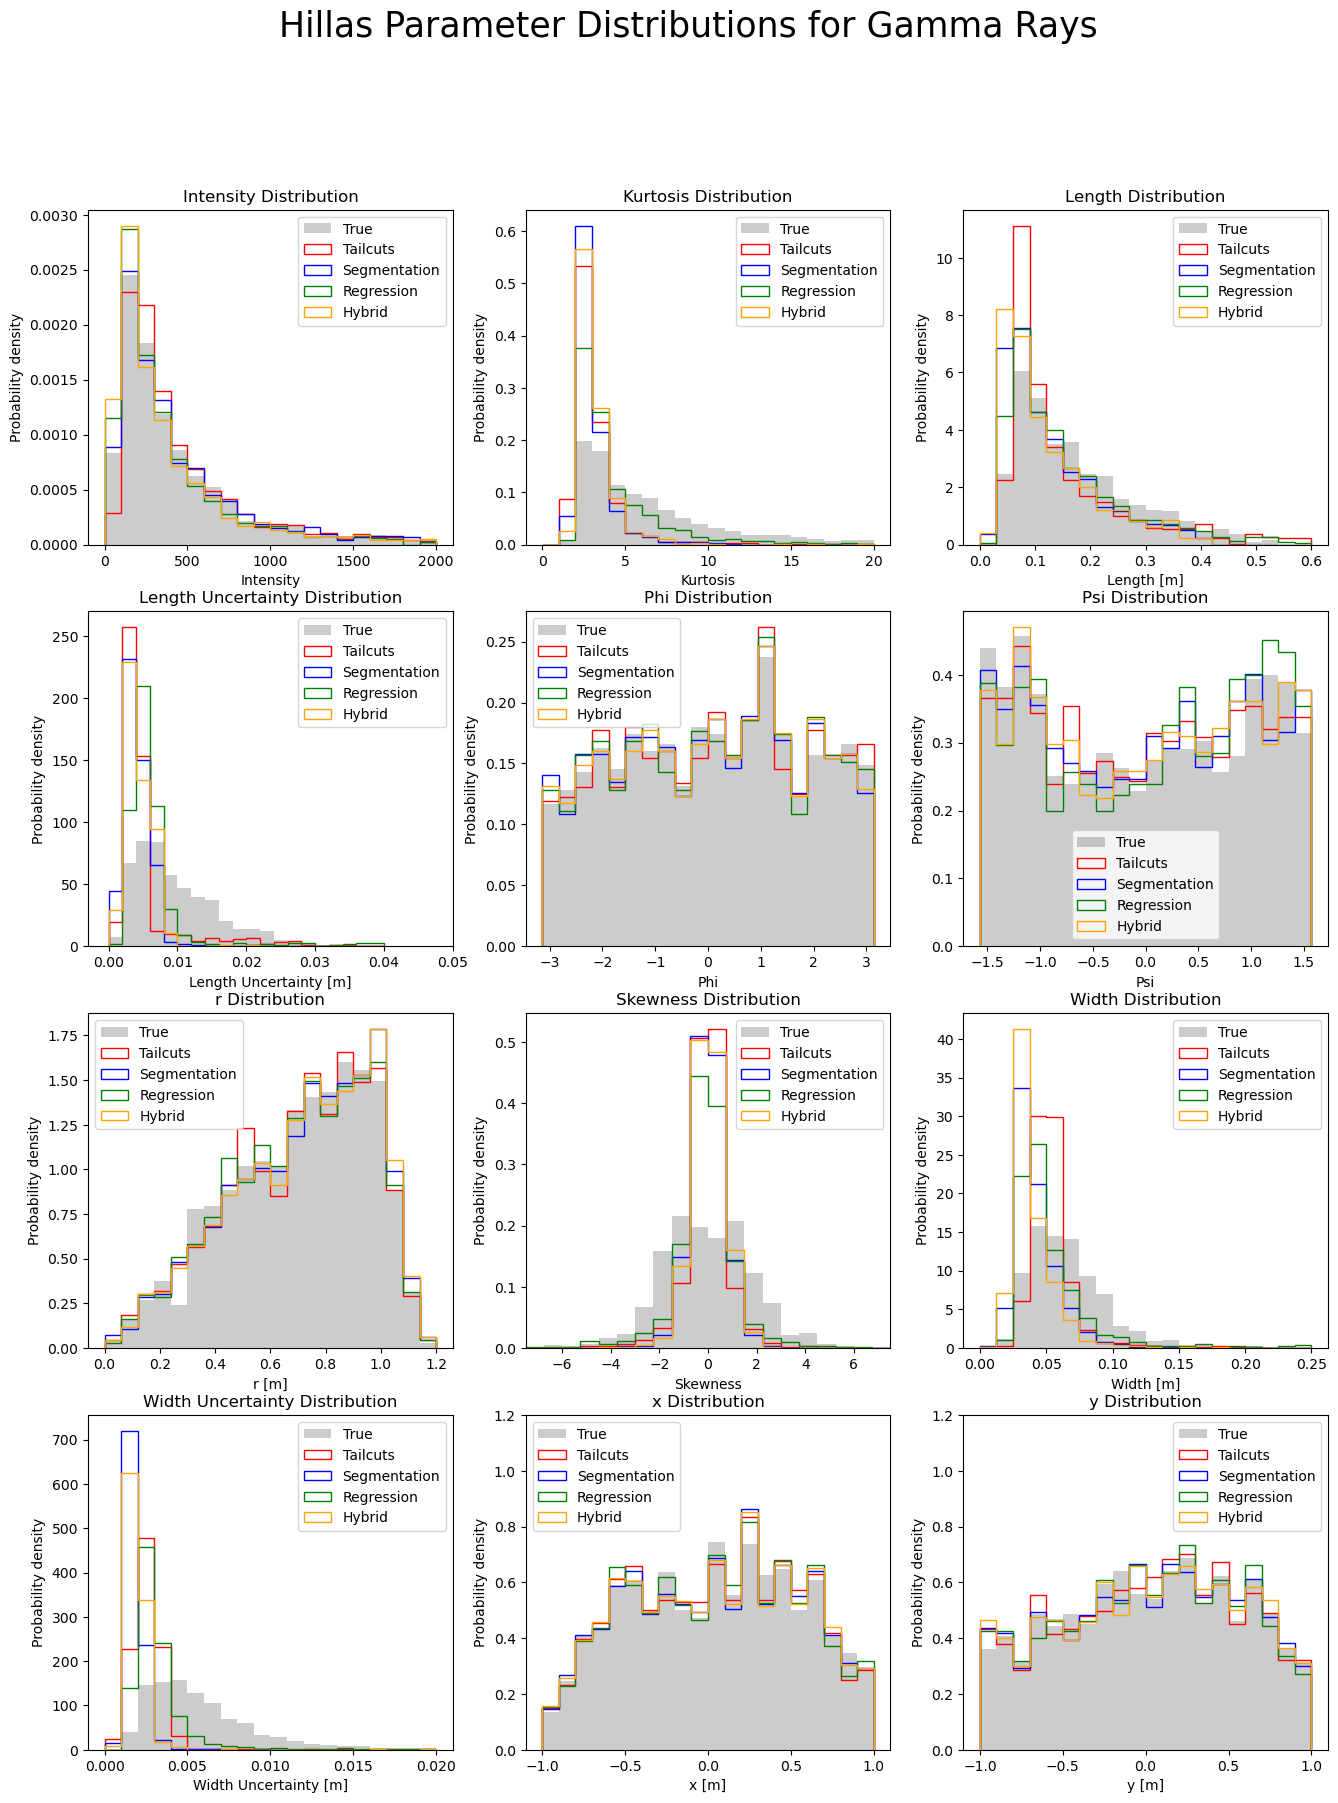

In [52]:
true_color = 'black'
tailcuts_color = 'red'
seg_color = 'blue'
reg_color = 'green'
hybrid_color = 'orange'

fig_hil_gamma, axs = plt.subplots(4,3,figsize=(16,20))

axs[0,0].hist(intensity_true, bins=20, range=(0,2000), alpha=0.2, density=True, color=true_color, label='True')
axs[0,0].hist(intensity_tailcuts, bins=20, range=(0,2000), density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[0,0].hist(intensity_seg, bins=20, range=(0,2000), density=True, color=seg_color, histtype='step', label='Segmentation')
axs[0,0].hist(intensity_reg, bins=20, range=(0,2000), density=True, color=reg_color, histtype='step', label='Regression')
axs[0,0].hist(intensity_hybrid, bins=20, range=(0,2000), density=True, color=hybrid_color, histtype='step', label='Hybrid')
axs[0,0].set_title('Intensity Distribution')
axs[0,0].set_xlabel("Intensity")
axs[0,0].set_ylabel("Probability density")
axs[0,0].legend()

axs[0,1].hist(kurtosis_true, bins=20, range=(0,20), alpha=0.2, density=True, color=true_color, label='True')
axs[0,1].hist(kurtosis_tailcuts, bins=20, range=(0,20), density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[0,1].hist(kurtosis_seg, bins=20, range=(0,20), density=True, color=seg_color, histtype='step', label='Segmentation')
axs[0,1].hist(kurtosis_reg, bins=20, range=(0,20), density=True, color=reg_color, histtype='step', label='Regression')
axs[0,1].hist(kurtosis_hybrid, bins=20, range=(0,20), density=True, color=hybrid_color, histtype='step', label='Hybrid')
axs[0,1].set_title('Kurtosis Distribution')
axs[0,1].set_xlabel("Kurtosis")
axs[0,1].set_ylabel("Probability density")
axs[0,1].legend()

axs[0,2].hist(length_true, bins=20, range=(0,0.6), alpha=0.2, density=True, color=true_color, label='True')
axs[0,2].hist(length_tailcuts, bins=20, range=(0,0.6), density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[0,2].hist(length_seg, bins=20, range=(0,0.6), density=True, color=seg_color, histtype='step', label='Segmentation')
axs[0,2].hist(length_reg, bins=20, range=(0,0.6), density=True, color=reg_color, histtype='step', label='Regression')
axs[0,2].hist(length_hybrid, bins=20, range=(0,0.6), density=True, color=hybrid_color, histtype='step', label='Hybrid')
axs[0,2].set_title('Length Distribution')
axs[0,2].set_xlabel("Length [m]")
axs[0,2].set_ylabel("Probability density")
axs[0,2].legend()

axs[1,0].hist(length_uncertainty_true, bins=20, range=(0,0.04), alpha=0.2, density=True, color=true_color, label='True')
axs[1,0].hist(length_uncertainty_tailcuts, bins=20, range=(0,0.04), density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[1,0].hist(length_uncertainty_seg, bins=20, range=(0,0.04), density=True, color=seg_color, histtype='step', label='Segmentation')
axs[1,0].hist(length_uncertainty_reg, bins=20, range=(0,0.04), density=True, color=reg_color, histtype='step', label='Regression')
axs[1,0].hist(length_uncertainty_hybrid, bins=20, range=(0,0.04), density=True, color=hybrid_color, histtype='step', label='Hybrid')
axs[1,0].set_title('Length Uncertainty Distribution')
axs[1,0].set_xlabel("Length Uncertainty [m]")
axs[1,0].set_ylabel("Probability density")
axs[1,0].set_xlim(-0.003,0.05)
axs[1,0].legend()

axs[1,1].hist(phi_true, bins=20, range=(-np.pi,np.pi), alpha=0.2, density=True, color=true_color, label='True')
axs[1,1].hist(phi_tailcuts, bins=20, range=(-np.pi,np.pi), density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[1,1].hist(phi_seg, bins=20, range=(-np.pi,np.pi), density=True, color=seg_color, histtype='step', label='Segmentation')
axs[1,1].hist(phi_reg, bins=20, range=(-np.pi,np.pi), density=True, color=reg_color, histtype='step', label='Regression')
axs[1,1].hist(phi_hybrid, bins=20, range=(-np.pi,np.pi), density=True, color=hybrid_color, histtype='step', label='Hybrid')
axs[1,1].set_title('Phi Distribution')
axs[1,1].set_xlabel("Phi")
axs[1,1].set_ylabel("Probability density")
axs[1,1].legend()

axs[1,2].hist(psi_true, bins=20, range=(-np.pi/2,np.pi/2), alpha=0.2, density=True, color=true_color, label='True')
axs[1,2].hist(psi_tailcuts, bins=20, range=(-np.pi/2,np.pi/2), density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[1,2].hist(psi_seg, bins=20, range=(-np.pi/2,np.pi/2), density=True, color=seg_color, histtype='step', label='Segmentation')
axs[1,2].hist(psi_reg, bins=20, range=(-np.pi/2,np.pi/2), density=True, color=reg_color, histtype='step', label='Regression')
axs[1,2].hist(psi_hybrid, bins=20, range=(-np.pi/2,np.pi/2), density=True, color=hybrid_color, histtype='step', label='Hybrid')
axs[1,2].set_title('Psi Distribution')
axs[1,2].set_xlabel("Psi")
axs[1,2].set_ylabel("Probability density")
axs[1,2].legend()

axs[2,0].hist(r_true, bins=20, range=(0,1.2), alpha=0.2, density=True, color=true_color, label='True')
axs[2,0].hist(r_tailcuts, bins=20, range=(0,1.2), density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[2,0].hist(r_seg, bins=20, range=(0,1.2), density=True, color=seg_color, histtype='step', label='Segmentation')
axs[2,0].hist(r_reg, bins=20, range=(0,1.2), density=True, color=reg_color, histtype='step', label='Regression')
axs[2,0].hist(r_hybrid, bins=20, range=(0,1.2), density=True, color=hybrid_color, histtype='step', label='Hybrid')
axs[2,0].set_title('r Distribution')
axs[2,0].set_xlabel("r [m]")
axs[2,0].set_ylabel("Probability density")
axs[2,0].legend()

axs[2,1].hist(skewness_true, bins=20, range=(-7.5,7.5), alpha=0.2, density=True, color=true_color, label='True')
axs[2,1].hist(skewness_tailcuts, bins=20, range=(-7.5,7.5), density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[2,1].hist(skewness_seg, bins=20, range=(-7.5,7.5), density=True, color=seg_color, histtype='step', label='Segmentation')
axs[2,1].hist(skewness_reg, bins=20, range=(-7.5,7.5), density=True, color=reg_color, histtype='step', label='Regression')
axs[2,1].hist(skewness_hybrid, bins=20, range=(-7.5,7.5), density=True, color=hybrid_color, histtype='step', label='Hybrid')
axs[2,1].set_xlim(-7.5,7.5)
axs[2,1].set_title('Skewness Distribution')
axs[2,1].set_xlabel("Skewness")
axs[2,1].set_ylabel("Probability density")
axs[2,1].legend()

axs[2,2].hist(width_true, bins=20, range=(0,0.25), alpha=0.2, density=True, color=true_color, label='True')
axs[2,2].hist(width_tailcuts, bins=20, range=(0,0.25), density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[2,2].hist(width_seg, bins=20, range=(0,0.25), density=True, color=seg_color, histtype='step', label='Segmentation')
axs[2,2].hist(width_reg, bins=20, range=(0,0.25), density=True, color=reg_color, histtype='step', label='Regression')
axs[2,2].hist(width_hybrid, bins=20, range=(0,0.25), density=True, color=hybrid_color, histtype='step', label='Hybrid')
axs[2,2].set_title('Width Distribution')
axs[2,2].set_xlabel("Width [m]")
axs[2,2].set_ylabel("Probability density")
axs[2,2].legend()

axs[3,0].hist(width_uncertainty_true, bins=20, range=(0,0.02), alpha=0.2, density=True, color=true_color, label='True')
axs[3,0].hist(width_uncertainty_tailcuts, bins=20, range=(0,0.02), density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[3,0].hist(width_uncertainty_seg, bins=20, range=(0,0.02), density=True, color=seg_color, histtype='step', label='Segmentation')
axs[3,0].hist(width_uncertainty_reg, bins=20, range=(0,0.02), density=True, color=reg_color, histtype='step', label='Regression')
axs[3,0].hist(width_uncertainty_hybrid, bins=20, range=(0,0.02), density=True, color=hybrid_color, histtype='step', label='Hybrid')
axs[3,0].set_title('Width Uncertainty Distribution')
axs[3,0].set_xlabel("Width Uncertainty [m]")
axs[3,0].set_ylabel("Probability density")
axs[3,0].legend()

axs[3,1].hist(x_true, bins=20, range=(-1,1), alpha=0.2, density=True, color=true_color, label='True')
axs[3,1].hist(x_tailcuts, bins=20, range=(-1,1), density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[3,1].hist(x_seg, bins=20, range=(-1,1), density=True, color=seg_color, histtype='step', label='Segmentation')
axs[3,1].hist(x_reg, bins=20, range=(-1,1), density=True, color=reg_color, histtype='step', label='Regression')
axs[3,1].hist(x_hybrid, bins=20, range=(-1,1), density=True, color=hybrid_color, histtype='step', label='Hybrid')
axs[3,1].set_ylim(0,1.2)
axs[3,1].set_title('x Distribution')
axs[3,1].set_xlabel("x [m]")
axs[3,1].set_ylabel("Probability density")
axs[3,1].legend()

axs[3,2].hist(y_true, bins=20, range=(-1,1), alpha=0.2, density=True, color=true_color, label='True')
axs[3,2].hist(y_tailcuts, bins=20, range=(-1,1), density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[3,2].hist(y_seg, bins=20, range=(-1,1), density=True, color=seg_color, histtype='step', label='Segmentation')
axs[3,2].hist(y_reg, bins=20, range=(-1,1), density=True, color=reg_color, histtype='step', label='Regression')
axs[3,2].hist(y_hybrid, bins=20, range=(-1,1), density=True, color=hybrid_color, histtype='step', label='Hybrid')
axs[3,2].set_ylim(0,1.2)
axs[3,2].set_title('y Distribution')
axs[3,2].set_xlabel("y [m]")
axs[3,2].set_ylabel("Probability density")
axs[3,2].legend()

fig_hil_gamma.suptitle("Hillas Parameter Distributions for Gamma Rays", fontsize=25)

plt.show()

fig_hil_gamma.savefig("images/HillasGamma.pdf")

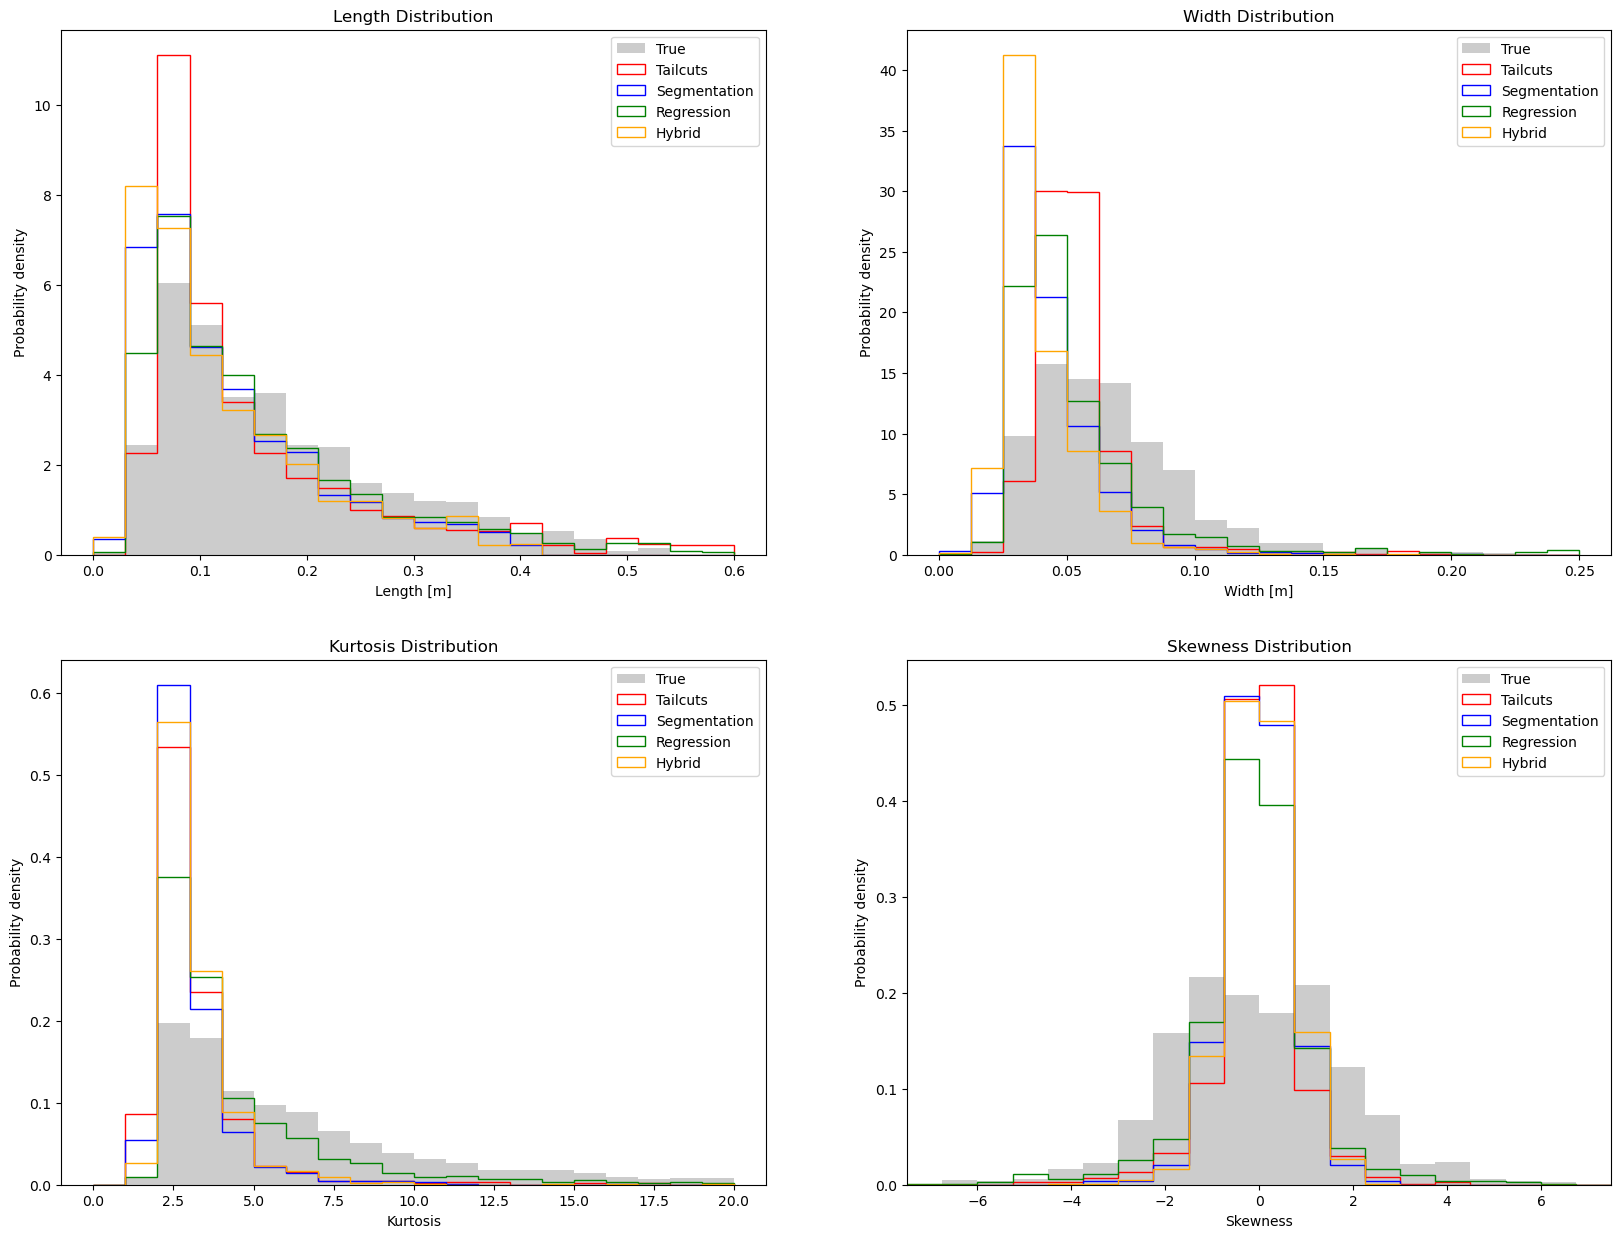

In [53]:
# Plot for report

fig_hil_res, axs = plt.subplots(2,2,figsize=(20,15))

axs[0,0].hist(length_true, bins=20, range=(0,0.6), alpha=0.2, density=True, color=true_color, label='True')
axs[0,0].hist(length_tailcuts, bins=20, range=(0,0.6), density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[0,0].hist(length_seg, bins=20, range=(0,0.6), density=True, color=seg_color, histtype='step', label='Segmentation')
axs[0,0].hist(length_reg, bins=20, range=(0,0.6), density=True, color=reg_color, histtype='step', label='Regression')
axs[0,0].hist(length_hybrid, bins=20, range=(0,0.6), density=True, color=hybrid_color, histtype='step', label='Hybrid')
axs[0,0].set_title('Length Distribution')
axs[0,0].set_xlabel("Length [m]")
axs[0,0].set_ylabel("Probability density")
axs[0,0].legend()

axs[0,1].hist(width_true, bins=20, range=(0,0.25), alpha=0.2, density=True, color=true_color, label='True')
axs[0,1].hist(width_tailcuts, bins=20, range=(0,0.25), density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[0,1].hist(width_seg, bins=20, range=(0,0.25), density=True, color=seg_color, histtype='step', label='Segmentation')
axs[0,1].hist(width_reg, bins=20, range=(0,0.25), density=True, color=reg_color, histtype='step', label='Regression')
axs[0,1].hist(width_hybrid, bins=20, range=(0,0.25), density=True, color=hybrid_color, histtype='step', label='Hybrid')
axs[0,1].set_title('Width Distribution')
axs[0,1].set_xlabel("Width [m]")
axs[0,1].set_ylabel("Probability density")
axs[0,1].legend()

axs[1,0].hist(kurtosis_true, bins=20, range=(0,20), alpha=0.2, density=True, color=true_color, label='True')
axs[1,0].hist(kurtosis_tailcuts, bins=20, range=(0,20), density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[1,0].hist(kurtosis_seg, bins=20, range=(0,20), density=True, color=seg_color, histtype='step', label='Segmentation')
axs[1,0].hist(kurtosis_reg, bins=20, range=(0,20), density=True, color=reg_color, histtype='step', label='Regression')
axs[1,0].hist(kurtosis_hybrid, bins=20, range=(0,20), density=True, color=hybrid_color, histtype='step', label='Hybrid')
axs[1,0].set_title('Kurtosis Distribution')
axs[1,0].set_xlabel("Kurtosis")
axs[1,0].set_ylabel("Probability density")
axs[1,0].legend()

axs[1,1].hist(skewness_true, bins=20, range=(-7.5,7.5), alpha=0.2, density=True, color=true_color, label='True')
axs[1,1].hist(skewness_tailcuts, bins=20, range=(-7.5,7.5), density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[1,1].hist(skewness_seg, bins=20, range=(-7.5,7.5), density=True, color=seg_color, histtype='step', label='Segmentation')
axs[1,1].hist(skewness_reg, bins=20, range=(-7.5,7.5), density=True, color=reg_color, histtype='step', label='Regression')
axs[1,1].hist(skewness_hybrid, bins=20, range=(-7.5,7.5), density=True, color=hybrid_color, histtype='step', label='Hybrid')
axs[1,1].set_xlim(-7.5,7.5)
axs[1,1].set_title('Skewness Distribution')
axs[1,1].set_xlabel("Skewness")
axs[1,1].set_ylabel("Probability density")
axs[1,1].legend()

plt.show()
fig_hil_res.savefig("images/HillasReport2.pdf")

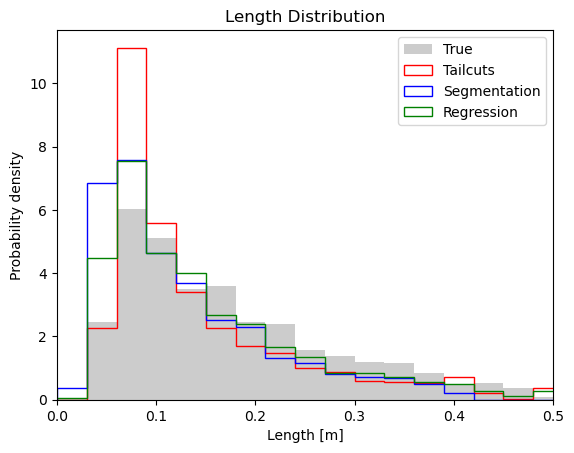

In [54]:
# Presentation figure

fig_length=plt.figure()

plt.hist(length_true, bins=20, range=(0,0.6), alpha=0.2, density=True, color=true_color, label='True')
plt.hist(length_tailcuts, bins=20, range=(0,0.6), density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
plt.hist(length_seg, bins=20, range=(0,0.6), density=True, color=seg_color, histtype='step', label='Segmentation')
plt.hist(length_reg, bins=20, range=(0,0.6), density=True, color=reg_color, histtype='step', label='Regression')
#plt.hist(length_hybrid, bins=20, range=(0,0.6), density=True, color=hybrid_color, histtype='step', label='Hybrid')
plt.title('Length Distribution')
plt.xlabel("Length [m]")
plt.ylabel("Probability density")
plt.legend()
plt.xlim(0, 0.5)

plt.show()
fig_length.savefig("images/HillasLength.pdf")

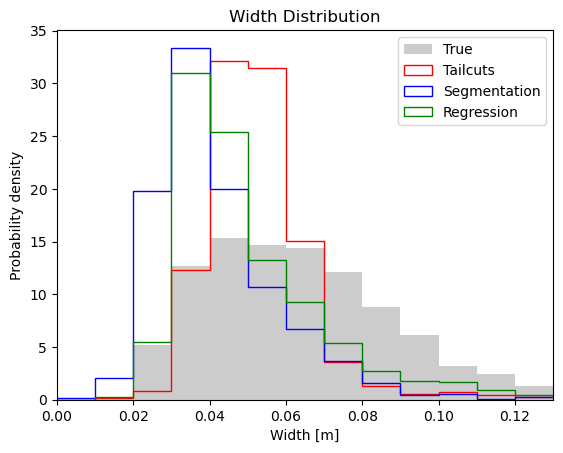

In [55]:
fig_width=plt.figure()

plt.hist(width_true, bins=25, range=(0,0.25), alpha=0.2, density=True, color=true_color, label='True')
plt.hist(width_tailcuts, bins=25, range=(0,0.25), density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
plt.hist(width_seg, bins=25, range=(0,0.25), density=True, color=seg_color, histtype='step', label='Segmentation')
plt.hist(width_reg, bins=25, range=(0,0.25), density=True, color=reg_color, histtype='step', label='Regression')
plt.xlim(0,0.13)
#plt.hist(width_hybrid, bins=20, range=(0,0.25), density=True, color=hybrid_color, histtype='step', label='Hybrid')
plt.title('Width Distribution')
plt.xlabel("Width [m]")
plt.ylabel("Probability density")
plt.legend()

plt.show()
fig_width.savefig("images/HillasWidth.pdf")

**Repeat for protons**

In [78]:
# The locations of the data
file_path_noisy = '/lustre/fs23/group/cta/users/amehta/summer_student_data/noisy_images/'
file_path_true = '/lustre/fs23/group/cta/users/amehta/summer_student_data/true_images/'

# Unpack 100 chunks of data
chunk_tot = 100

data_noisy_tot = np.array([])
data_true_tot = np.array([])
data_target_tot = np.array([])

for chunk_i in range(0,chunk_tot):
    data_noisy_all = load_chunk_file(file_path_noisy, chunk_i)
    data_noisy_chunk = np.array(data_noisy_all[0])
    data_noisy_tot = np.append(data_noisy_tot, data_noisy_chunk)
    
    data_true_all = load_chunk_file(file_path_true, chunk_i)
    data_true_chunk = np.array(data_true_all[0])
    data_true_tot = np.append(data_true_tot, data_true_chunk)
    
    data_target_chunk = np.array(data_noisy_all[1])
    data_target_tot = np.append(data_target_tot, data_target_chunk)
    
    
# Get it in the right shape
data_noisy = data_noisy_tot.reshape(128*chunk_tot, 56, 56)
data_true = data_true_tot.reshape(128*chunk_tot, 56, 56)
data_target = data_target_tot.reshape(128*chunk_tot)

In [79]:
# Make a mask of the locations of the nans, so that we can put them back in after fitting.

nan_mask = np.isnan(data_noisy[0])
data_noisy_nonan = np.nan_to_num(data_noisy)

# Look at the sum of all the pixels for the noisy and true images

images_noisy_sum = np.nansum(data_noisy, axis=(1,2))
images_true_sum = np.nansum(data_true, axis=(1,2))

images_high_mask = (images_noisy_sum>60)

# Look at the true images only with pixels of 0 and 1 (non-signal and signal)
# For the purpose of the classification

threshold = 0

data_true_binary = np.zeros((128*chunk_tot, 56, 56))
data_true_binary[data_true>threshold] = 1
data_true_binary_flat = data_true_binary.reshape((128*chunk_tot, 56*56))

# Putting them to the right form with normalization
data_noisy_arr = data_noisy[images_high_mask]
pix_max = np.nanmax(data_noisy_arr, axis=(1,2))[:, np.newaxis, np.newaxis]
pix_min = np.nanmin(data_noisy_arr, axis=(1,2))[:, np.newaxis, np.newaxis]
data_noisy_norm = np.nan_to_num((data_noisy_arr - pix_min)/(pix_max-pix_min))

data_noisy_tensor = (torch.from_numpy(data_noisy_norm).float())
data_noisy_tensor = (torch.from_numpy(data_noisy_nonan[images_high_mask]).float())
data_true_tensor = (torch.from_numpy(data_true_binary_flat[images_high_mask])).float()

data_noisy_tensor_im = (torch.from_numpy(data_noisy[images_high_mask])).float()
data_true_tensor_im = (torch.from_numpy(data_true[images_high_mask])).float()

# Split train and test

N, w, h = data_noisy_tensor.shape
idx_split = int(N*0.8) # 80% training, 20% testing
data_noisy_train = data_noisy_tensor[:idx_split]
data_true_train = data_true_tensor[:idx_split]
data_noisy_test = data_noisy_tensor[idx_split:][data_target_test==0]
data_true_test = data_true_tensor[idx_split:][data_target_test==0]

data_noisy_train_im = data_noisy_tensor_im[:idx_split]
data_true_train_im = data_true_tensor_im[:idx_split]
data_noisy_test_im = data_noisy_tensor_im[idx_split:][data_target_test==0]
data_true_test_im = data_true_tensor_im[idx_split:][data_target_test==0]

data_noisy_train = data_noisy_train.detach().numpy()
data_true_train = data_true_train.detach().numpy()
data_noisy_test = (data_noisy_test.detach().numpy())
data_true_test = (data_true_test.detach().numpy())

In [80]:
# Now with a minimum of 0

nan_mask = np.isnan(data_noisy[0])
data_noisy_nonan = np.nan_to_num(data_noisy)
data_true_nonan = np.nan_to_num(data_true)

# Look at the sum of all the pixels for the noisy and true images

images_noisy_sum = np.nansum(data_noisy, axis=(1,2))
images_true_sum = np.nansum(data_true, axis=(1,2))

images_high_mask = (images_noisy_sum>60)

# Look at the true images only with pixels of 0 and 1 (non-signal and signal)
# For the purpose of the classification

threshold = 0

data_true_nonan_flat = data_true_nonan.reshape((128*chunk_tot, 56*56))

# Putting them to the right form with normalization
data_noisy_arr = data_noisy[images_high_mask]
data_noisy_arr[np.nan_to_num(data_noisy_arr)<0] = 0

pix_max_noisy = np.nanmax(data_noisy_arr, axis=(1,2))[:, np.newaxis, np.newaxis]
data_noisy_norm = np.nan_to_num(data_noisy_arr/pix_max_noisy)
data_noisy_tensor = (torch.from_numpy(data_noisy_norm).float())


# Now normalize the true data in the same way as the noisy data

data_true_arr = data_true_nonan_flat[images_high_mask]
pix_max_true = np.nanmax(data_noisy_arr, axis=(1,2))[:, np.newaxis]
data_true_norm = np.nan_to_num(data_true_arr/pix_max_true)
data_true_tensor = (torch.from_numpy(data_true_norm).float())

data_noisy_tensor_im = (torch.from_numpy(data_noisy[images_high_mask])).float()

data_true_tensor_im = (torch.from_numpy(data_true[images_high_mask])).float()

# Split train and test

N, w, h = data_noisy_tensor.shape
idx_split = int(N*0.8) # 80% training, 20% testing
data_target_train = (data_target[images_high_mask])[:idx_split]
data_target_test = (data_target)[images_high_mask][idx_split:]
data_noisy_train = data_noisy_tensor[:idx_split]
data_true_train = data_true_tensor[:idx_split]
data_noisy_test_n = (data_noisy_tensor[idx_split:])[data_target_test==0]
data_true_test_n = (data_true_tensor[idx_split:])[data_target_test==0]

data_noisy_train_im = data_noisy_tensor_im[:idx_split]
data_true_train_im = data_true_tensor_im[:idx_split]
data_noisy_test_im_n = (data_noisy_tensor_im[idx_split:])[data_target_test==0]
data_true_test_im_n = (data_true_tensor_im[idx_split:])[data_target_test==0]



**Proton: True**

In [82]:
intensity_list = []
kurtosis_list = []
length_list = []
length_uncertainty_list = []
phi_list = []
psi_list = []
r_list = []
skewness_list = []
width_list = []
width_uncertainty_list = []
x_list = []
y_list = []

geom = ctapipe.instrument.camera.geometry.CameraGeometry.from_name('FlashCam')
for true in data_true_test_im:
    #true = true.reshape(56,56)
    true = true.detach().numpy()
    true_img = geom.image_from_cartesian_representation(true)
    try:
        hil_par = hillas.hillas_parameters(geom, true_img)
        intensity_list.append(hil_par['intensity'])
        kurtosis_list.append(hil_par['kurtosis'])
        length_list.append(hil_par['length'].value)
        length_uncertainty_list.append(hil_par['length_uncertainty'].value)
        phi_list.append(hil_par['phi'].value)
        psi_list.append(hil_par['psi'].value)
        r_list.append(hil_par['r'].value)
        skewness_list.append(hil_par['skewness'])
        width_list.append(hil_par['width'].value)
        width_uncertainty_list.append(hil_par['width_uncertainty'].value)
        x_list.append(hil_par['x'].value)
        y_list.append(hil_par['y'].value)
    except:
        pass


intensity_true_p = np.array(intensity_list)
kurtosis_true_p = np.array(kurtosis_list)
length_true_p = np.array(length_list)
length_uncertainty_true_p = np.array(length_uncertainty_list)
phi_true_p = np.array(phi_list)
psi_true_p = np.array(psi_list)
r_true_p = np.array(r_list)
skewness_true_p = np.array(skewness_list)
width_true_p = np.array(width_list)
width_uncertainty_true_p = np.array(width_uncertainty_list)
x_true_p = np.array(x_list)
y_true_p = np.array(y_list)

**Proton: Tailcuts**

In [84]:
intensity_list = []
kurtosis_list = []
length_list = []
length_uncertainty_list = []
phi_list = []
psi_list = []
r_list = []
skewness_list = []
width_list = []
width_uncertainty_list = []
x_list = []
y_list = []

geom = ctapipe.instrument.camera.geometry.CameraGeometry.from_name('FlashCam')
for noisy in data_noisy_test:
    clean = get_cleaned_chunk_image(noisy)
    clean[clean<0] = 0
    clean_img = geom.image_from_cartesian_representation(clean)
    try:
        hil_par = hillas.hillas_parameters(geom, clean_img)
        intensity_list.append(hil_par['intensity'])
        kurtosis_list.append(hil_par['kurtosis'])
        length_list.append(hil_par['length'].value)
        length_uncertainty_list.append(hil_par['length_uncertainty'].value)
        phi_list.append(hil_par['phi'].value)
        psi_list.append(hil_par['psi'].value)
        r_list.append(hil_par['r'].value)
        skewness_list.append(hil_par['skewness'])
        width_list.append(hil_par['width'].value)
        width_uncertainty_list.append(hil_par['width_uncertainty'].value)
        x_list.append(hil_par['x'].value)
        y_list.append(hil_par['y'].value)
        
    except:
        pass


intensity_tailcuts_p = np.array(intensity_list)
kurtosis_tailcuts_p = np.array(kurtosis_list)
length_tailcuts_p = np.array(length_list)
length_uncertainty_tailcuts_p = np.array(length_uncertainty_list)
phi_tailcuts_p = np.array(phi_list)
psi_tailcuts_p = np.array(psi_list)
r_tailcuts_p = np.array(r_list)
skewness_tailcuts_p = np.array(skewness_list)
width_tailcuts_p = np.array(width_list)
width_uncertainty_tailcuts_p = np.array(width_uncertainty_list)
x_tailcuts_p = np.array(x_list)
y_tailcuts_p = np.array(y_list)

**Proton: Segmentation**

In [86]:
intensity_list = []
kurtosis_list = []
length_list = []
length_uncertainty_list = []
phi_list = []
psi_list = []
r_list = []
skewness_list = []
width_list = []
width_uncertainty_list = []
x_list = []
y_list = []

geom = ctapipe.instrument.camera.geometry.CameraGeometry.from_name('FlashCam')
for noisy in data_noisy_test:
    noisy = torch.tensor(noisy)
    noisy = noisy.unsqueeze(0)
    output = network_seg(noisy)
    output = F.sigmoid(output)
    im_clean = output.reshape(1, 56, 56)
    im_clean_prob = im_clean.detach()[0].numpy()

    im_clean = im_clean_prob.round()
    mask_clean = im_clean.astype(bool)
    im_clean_good = np.zeros((56,56))

    im_clean_good[mask_clean] = noisy[0][mask_clean]
    im_clean_good[im_clean_good<0] = 0
    im_clean_good[nan_mask] = np.nan
    
    true_img = geom.image_from_cartesian_representation(im_clean_good)

    try:
        hil_par = hillas.hillas_parameters(geom, true_img)
        intensity_list.append(hil_par['intensity'])
        kurtosis_list.append(hil_par['kurtosis'])
        length_list.append(hil_par['length'].value)
        length_uncertainty_list.append(hil_par['length_uncertainty'].value)
        phi_list.append(hil_par['phi'].value)
        psi_list.append(hil_par['psi'].value)
        r_list.append(hil_par['r'].value)
        skewness_list.append(hil_par['skewness'])
        width_list.append(hil_par['width'].value)
        width_uncertainty_list.append(hil_par['width_uncertainty'].value)
        x_list.append(hil_par['x'].value)
        y_list.append(hil_par['y'].value)
    except:
        pass


intensity_seg_p = np.array(intensity_list)
kurtosis_seg_p = np.array(kurtosis_list)
length_seg_p = np.array(length_list)
length_uncertainty_seg_p = np.array(length_uncertainty_list)
phi_seg_p = np.array(phi_list)
psi_seg_p = np.array(psi_list)
r_seg_p = np.array(r_list)
skewness_seg_p = np.array(skewness_list)
width_seg_p = np.array(width_list)
width_uncertainty_seg_p = np.array(width_uncertainty_list)
x_seg_p = np.array(x_list)
y_seg_p = np.array(y_list)

**Proton: Regression**

In [87]:
pix_max_test = pix_max_noisy[idx_split:]

intensity_list = []
kurtosis_list = []
length_list = []
length_uncertainty_list = []
phi_list = []
psi_list = []
r_list = []
skewness_list = []
width_list = []
width_uncertainty_list = []
x_list = []
y_list = []

geom = ctapipe.instrument.camera.geometry.CameraGeometry.from_name('FlashCam')
i=0
for noisy in data_noisy_test_n:
    output = network_reg(noisy.unsqueeze(0))
    clean_norm = output.data
    clean = clean_norm*pix_max_test[i]
    clean = np.round(clean)
    clean = clean.reshape(56,56)
    clean[nan_mask] = np.nan
    clean = clean.detach().numpy()
    clean[clean<0] = 0
    
    
    true_img = geom.image_from_cartesian_representation(clean)

    try:
        hil_par = hillas.hillas_parameters(geom, true_img)
        intensity_list.append(hil_par['intensity'])
        kurtosis_list.append(hil_par['kurtosis'])
        length_list.append(hil_par['length'].value)
        length_uncertainty_list.append(hil_par['length_uncertainty'].value)
        phi_list.append(hil_par['phi'].value)
        psi_list.append(hil_par['psi'].value)
        r_list.append(hil_par['r'].value)
        skewness_list.append(hil_par['skewness'])
        width_list.append(hil_par['width'].value)
        width_uncertainty_list.append(hil_par['width_uncertainty'].value)
        x_list.append(hil_par['x'].value)
        y_list.append(hil_par['y'].value)
    except:
        pass
    
    i=i+1



intensity_reg_p = np.array(intensity_list)
kurtosis_reg_p = np.array(kurtosis_list)
length_reg_p = np.array(length_list)
length_uncertainty_reg_p = np.array(length_uncertainty_list)
phi_reg_p = np.array(phi_list)
psi_reg_p = np.array(psi_list)
r_reg_p = np.array(r_list)
skewness_reg_p = np.array(skewness_list)
width_reg_p = np.array(width_list)
width_uncertainty_reg_p = np.array(width_uncertainty_list)
x_reg_p = np.array(x_list)
y_reg_p = np.array(y_list)

**Proton: Hybrid**

In [90]:
# Prepare test data

data_true_test_con = data_true[images_high_mask][idx_split:]

i=0

data_noisy_test_reg = np.zeros(data_noisy_test.shape)
data_true_test_reg = np.zeros(data_true_test_con.shape)
mask_clean_test_reg = np.zeros(data_noisy_test.shape)

for noisy, true, pixmax in zip(data_noisy_test, data_true_test_con, pix_max_test):
    output = network_seg(torch.tensor(data_noisy_test[i]).unsqueeze(0))
    
    output = F.sigmoid(output)
    im_clean = output.reshape(1, 56, 56)
    im_clean_prob = im_clean.detach()[0].numpy()

    im_clean = im_clean_prob.round()
    mask_clean = im_clean.astype(bool)
    im_clean_good = np.zeros((56,56))

    im_clean_good[mask_clean] = data_noisy_test_im[i][mask_clean]
    im_clean_good[im_clean_good<0] = 0
    im_clean_good = im_clean_good/pixmax
    
    #im_clean_good[nan_mask] = 0
    true = true/pixmax
    true[nan_mask] = 0
    
    data_noisy_test_reg[i] = im_clean_good
    data_true_test_reg[i] = true
    mask_clean_test_reg[i] = mask_clean
    
    i=i+1

data_noisy_test_reg_p = np.nan_to_num(data_noisy_test_reg)
data_true_test_reg_p = np.nan_to_num(data_true_test_reg)
data_noisy_test_reg_p = torch.tensor(data_noisy_test_reg)
data_true_test_reg_p = torch.tensor(data_true_test_reg)
mask_clean_test_reg_p = torch.tensor(mask_clean_test_reg)

In [91]:
intensity_list = []
kurtosis_list = []
length_list = []
length_uncertainty_list = []
phi_list = []
psi_list = []
r_list = []
skewness_list = []
width_list = []
width_uncertainty_list = []
x_list = []
y_list = []

geom = ctapipe.instrument.camera.geometry.CameraGeometry.from_name('FlashCam')
i=0
for noisy in data_noisy_test_reg_p:
    output = network(noisy.unsqueeze(0).float())
    clean_norm = output.data
    clean = clean_norm*pix_max_test[i]
    clean = clean.reshape(56,56) * mask_clean_test_reg[i]
    clean[nan_mask] = np.nan
    clean = clean.detach().numpy()
    clean[clean<0] = 0
    
    true_img = geom.image_from_cartesian_representation(clean)

    try:
        hil_par = hillas.hillas_parameters(geom, true_img)
        intensity_list.append(hil_par['intensity'])
        kurtosis_list.append(hil_par['kurtosis'])
        length_list.append(hil_par['length'].value)
        length_uncertainty_list.append(hil_par['length_uncertainty'].value)
        phi_list.append(hil_par['phi'].value)
        psi_list.append(hil_par['psi'].value)
        r_list.append(hil_par['r'].value)
        skewness_list.append(hil_par['skewness'])
        width_list.append(hil_par['width'].value)
        width_uncertainty_list.append(hil_par['width_uncertainty'].value)
        x_list.append(hil_par['x'].value)
        y_list.append(hil_par['y'].value)
    except:
        pass
    
    i=i+1
    



intensity_hybrid_p = np.array(intensity_list)
kurtosis_hybrid_p = np.array(kurtosis_list)
length_hybrid_p = np.array(length_list)
length_uncertainty_hybrid_p = np.array(length_uncertainty_list)
phi_hybrid_p = np.array(phi_list)
psi_hybrid_p = np.array(psi_list)
r_hybrid_p = np.array(r_list)
skewness_hybrid_p = np.array(skewness_list)
width_hybrid_p = np.array(width_list)
width_uncertainty_hybrid_p = np.array(width_uncertainty_list)
x_hybrid_p = np.array(x_list)
y_hybrid_p = np.array(y_list)

In [92]:
true_color = 'black'
tailcuts_color = 'red'
seg_color = 'blue'
reg_color = 'green'
hybrid_color = 'orange'

fig, axs = plt.subplots(4,3,figsize=(16,20))

axs[0,0].hist(intensity_true_p, bins=50, range=(0,3000), density=True, color=true_color, histtype='step', label='True')
axs[0,0].hist(intensity_tailcuts_p, bins=50, range=(0,3000), density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[0,0].hist(intensity_seg_p, bins=50, range=(0,3000), density=True, color='blue', histtype='step', label='Segmentation')
axs[0,0].hist(intensity_reg_p, bins=50, range=(0,3000), density=True, color='green', histtype='step', label='Regression')
axs[0,0].hist(intensity_hybrid_p, bins=20, range=(0,3000), density=True, color=hybrid_color, histtype='step', label='Hybrid'
axs[0,0].set_title('Intensity Distribution')
axs[0,0].set_xlabel("Intensity")
axs[0,0].set_ylabel("Counts")
axs[0,0].legend()

axs[0,1].hist(kurtosis_true_p, bins=50, range=(0,30), density=True, color=true_color, histtype='step', label='True')
axs[0,1].hist(kurtosis_tailcuts_p, bins=50, range=(0,30), density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[0,1].hist(kurtosis_seg_p, bins=50, range=(0,30), density=True, color=seg_color, histtype='step', label='Segmentation')
axs[0,1].hist(kurtosis_reg_p, bins=50, range=(0,30), density=True, color=reg_color, histtype='step', label='Regression')
axs[0,1].set_title('Kurtosis Distribution')
axs[0,1].set_xlabel("Kurtosis")
axs[0,1].set_ylabel("Counts")
axs[0,1].legend()

axs[0,2].hist(length_true_p, bins=30, density=True, color=true_color, histtype='step', label='True')
axs[0,2].hist(length_tailcuts_p, bins=30, density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[0,2].hist(length_seg_p, bins=30, density=True, color=seg_color, histtype='step', label='Segmentation')
axs[0,2].hist(length_reg_p, bins=30, density=True, color=reg_color, histtype='step', label='Regression')
axs[0,2].set_title('Length Distribution')
axs[0,2].set_xlabel("Length")
axs[0,2].set_ylabel("Counts")
axs[0,2].legend()

axs[1,0].hist(length_uncertainty_true_p, bins=20, density=True, color=true_color, histtype='step', label='True')
axs[1,0].hist(length_uncertainty_tailcuts_p, bins=20, density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[1,0].hist(length_uncertainty_seg_p, bins=20, density=True, color=seg_color, histtype='step', label='Segmentation')
axs[1,0].hist(length_uncertainty_reg_p, bins=20, density=True, color=reg_color, histtype='step', label='Regression')
axs[1,0].set_title('Length Uncertainty Distribution')
axs[1,0].set_xlabel("Length Uncertainty")
axs[1,0].set_ylabel("Counts")
axs[1,0].legend()

axs[1,1].hist(phi_true_p, bins=20, density=True, color=true_color, histtype='step', label='True')
axs[1,1].hist(phi_tailcuts_p, bins=20, density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[1,1].hist(phi_seg_p, bins=20, density=True, color=seg_color, histtype='step', label='Segmentation')
axs[1,1].hist(phi_reg_p, bins=20, density=True, color=reg_color, histtype='step', label='Regression')
axs[1,1].set_title('Phi Distribution')
axs[1,1].set_xlabel("Phi")
axs[1,1].set_ylabel("Counts")
axs[1,1].legend()

axs[1,2].hist(psi_true_p, bins=20, density=True, color=true_color, histtype='step', label='True')
axs[1,2].hist(psi_tailcuts_p, bins=20, density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[1,2].hist(psi_seg_p, bins=20, density=True, color=seg_color, histtype='step', label='Segmentation')
axs[1,2].hist(psi_reg_p, bins=20, density=True, color=reg_color, histtype='step', label='Regression')
axs[1,2].set_title('Psi Distribution')
axs[1,2].set_xlabel("Psi")
axs[1,2].set_ylabel("Counts")
axs[1,2].legend()

axs[2,0].hist(r_true_p, bins=20, density=True, color=true_color, histtype='step', label='True')
axs[2,0].hist(r_tailcuts_p, bins=20, density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[2,0].hist(r_seg_p, bins=20, density=True, color=seg_color, histtype='step', label='Segmentation')
axs[2,0].hist(r_reg_p, bins=20, density=True, color=reg_color, histtype='step', label='Regression')
axs[2,0].set_title('r Distribution')
axs[2,0].set_xlabel("r")
axs[2,0].set_ylabel("Counts")
axs[2,0].legend()

axs[2,1].hist(skewness_true_p, bins=50, density=True, color=true_color, histtype='step', label='True')
axs[2,1].hist(skewness_tailcuts_p, bins=50, density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[2,1].hist(skewness_seg_p, bins=50, density=True, color=seg_color, histtype='step', label='Segmentation')
axs[2,1].hist(skewness_reg_p, bins=50, density=True, color=reg_color, histtype='step', label='Regression')
axs[2,1].set_title('Skewness Distribution')
axs[2,1].set_xlabel("Skewness")
axs[2,1].set_ylabel("Counts")
axs[2,1].legend()

axs[2,2].hist(width_true_p, bins=50, density=True, color=true_color, histtype='step', label='True')
axs[2,2].hist(width_tailcuts_p, bins=50, density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[2,2].hist(width_seg_p, bins=50, density=True, color=seg_color, histtype='step', label='Segmentation')
axs[2,2].hist(width_reg_p, bins=50, density=True, color=reg_color, histtype='step', label='Regression')
axs[2,2].set_title('Width Distribution')
axs[2,2].set_xlabel("Width")
axs[2,2].set_ylabel("Counts")
axs[2,2].legend()

axs[3,0].hist(width_uncertainty_true_p, bins=30, density=True, color=true_color, histtype='step', label='True')
axs[3,0].hist(width_uncertainty_tailcuts_p, bins=30, density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[3,0].hist(width_uncertainty_seg_p, bins=30, density=True, color=seg_color, histtype='step', label='Segmentation')
axs[3,0].hist(width_uncertainty_reg_p, bins=30, density=True, color=reg_color, histtype='step', label='Regression')
axs[3,0].set_title('Width Uncertainty Distribution')
axs[3,0].set_xlabel("Width Uncertainty")
axs[3,0].set_ylabel("Counts")
axs[3,0].legend()

axs[3,1].hist(x_true_p, bins=20, density=True, color=true_color, histtype='step', label='True')
axs[3,1].hist(x_tailcuts_p, bins=20, density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[3,1].hist(x_seg_p, bins=20, density=True, color=seg_color, histtype='step', label='Segmentation')
axs[3,1].hist(x_reg_p, bins=20, density=True, color=reg_color, histtype='step', label='Regression')
axs[3,1].set_title('x Distribution')
axs[3,1].set_xlabel("x")
axs[3,1].set_ylabel("Counts")
axs[3,1].legend()

axs[3,2].hist(y_true_p, bins=20, density=True, color=true_color, histtype='step', label='True')
axs[3,2].hist(y_tailcuts_p, bins=20, density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[3,2].hist(y_seg_p, bins=20, density=True, color=seg_color, histtype='step', label='Segmentation')
axs[3,2].hist(y_reg_p, bins=20, density=True, color=reg_color, histtype='step', label='Regression')
axs[3,2].set_title('y Distribution')
axs[3,2].set_xlabel("y")
axs[3,2].set_ylabel("Counts")
axs[3,2].legend()

plt.show()

SyntaxError: invalid syntax (2396133562.py, line 14)

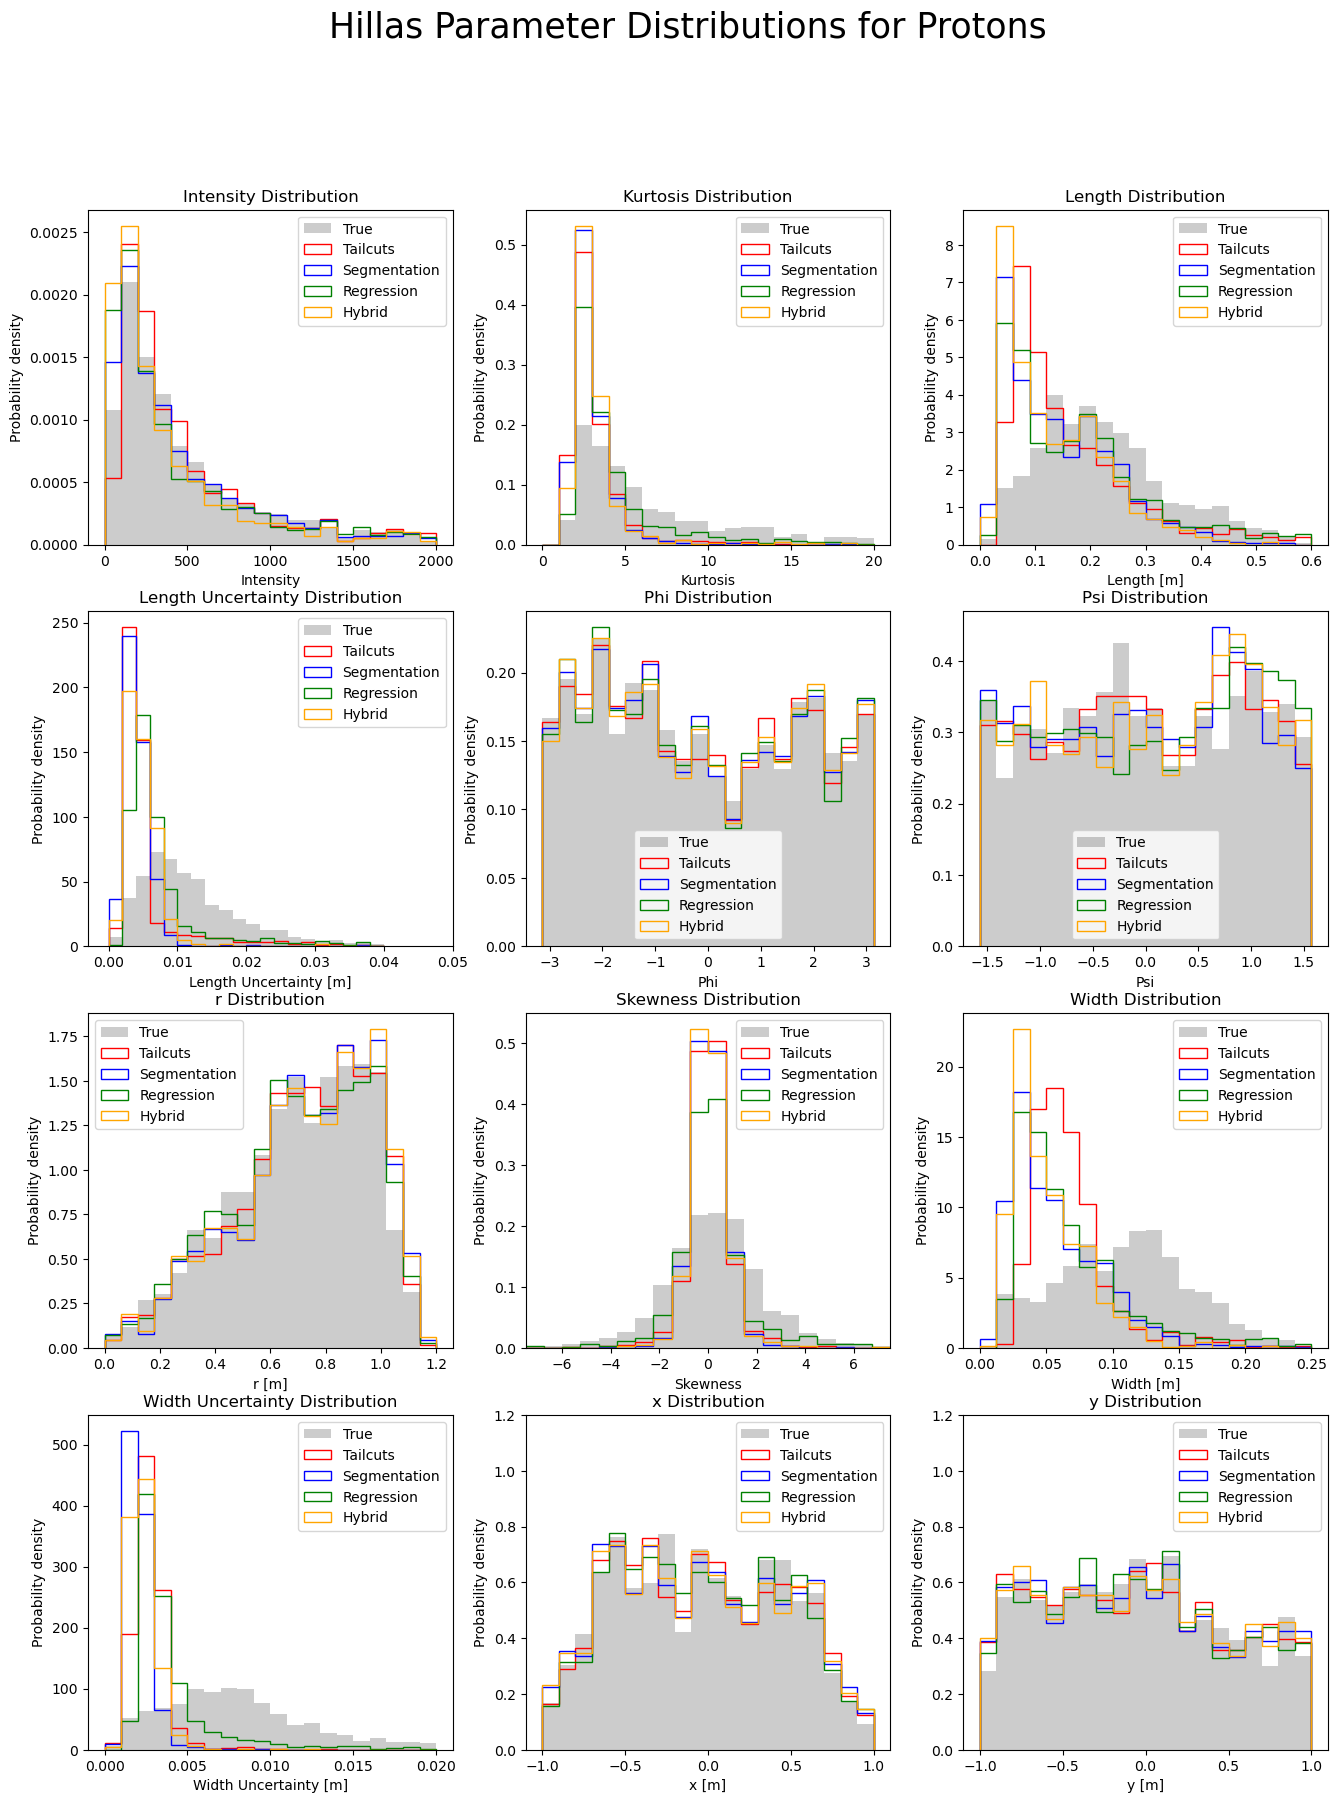

In [93]:
true_color = 'black'
tailcuts_color = 'red'
seg_color = 'blue'
reg_color = 'green'
hybrid_color = 'orange'

fig_hil_gamma, axs = plt.subplots(4,3,figsize=(16,20))

axs[0,0].hist(intensity_true_p, bins=20, range=(0,2000), alpha=0.2, density=True, color=true_color, label='True')
axs[0,0].hist(intensity_tailcuts_p, bins=20, range=(0,2000), density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[0,0].hist(intensity_seg_p, bins=20, range=(0,2000), density=True, color=seg_color, histtype='step', label='Segmentation')
axs[0,0].hist(intensity_reg_p, bins=20, range=(0,2000), density=True, color=reg_color, histtype='step', label='Regression')
axs[0,0].hist(intensity_hybrid_p, bins=20, range=(0,2000), density=True, color=hybrid_color, histtype='step', label='Hybrid')
axs[0,0].set_title('Intensity Distribution')
axs[0,0].set_xlabel("Intensity")
axs[0,0].set_ylabel("Probability density")
axs[0,0].legend()

axs[0,1].hist(kurtosis_true_p, bins=20, range=(0,20), alpha=0.2, density=True, color=true_color, label='True')
axs[0,1].hist(kurtosis_tailcuts_p, bins=20, range=(0,20), density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[0,1].hist(kurtosis_seg_p, bins=20, range=(0,20), density=True, color=seg_color, histtype='step', label='Segmentation')
axs[0,1].hist(kurtosis_reg_p, bins=20, range=(0,20), density=True, color=reg_color, histtype='step', label='Regression')
axs[0,1].hist(kurtosis_hybrid_p, bins=20, range=(0,20), density=True, color=hybrid_color, histtype='step', label='Hybrid')
axs[0,1].set_title('Kurtosis Distribution')
axs[0,1].set_xlabel("Kurtosis")
axs[0,1].set_ylabel("Probability density")
axs[0,1].legend()

axs[0,2].hist(length_true_p, bins=20, range=(0,0.6), alpha=0.2, density=True, color=true_color, label='True')
axs[0,2].hist(length_tailcuts_p, bins=20, range=(0,0.6), density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[0,2].hist(length_seg_p, bins=20, range=(0,0.6), density=True, color=seg_color, histtype='step', label='Segmentation')
axs[0,2].hist(length_reg_p, bins=20, range=(0,0.6), density=True, color=reg_color, histtype='step', label='Regression')
axs[0,2].hist(length_hybrid_p, bins=20, range=(0,0.6), density=True, color=hybrid_color, histtype='step', label='Hybrid')
axs[0,2].set_title('Length Distribution')
axs[0,2].set_xlabel("Length [m]")
axs[0,2].set_ylabel("Probability density")
axs[0,2].legend()

axs[1,0].hist(length_uncertainty_true_p, bins=20, range=(0,0.04), alpha=0.2, density=True, color=true_color, label='True')
axs[1,0].hist(length_uncertainty_tailcuts_p, bins=20, range=(0,0.04), density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[1,0].hist(length_uncertainty_seg_p, bins=20, range=(0,0.04), density=True, color=seg_color, histtype='step', label='Segmentation')
axs[1,0].hist(length_uncertainty_reg_p, bins=20, range=(0,0.04), density=True, color=reg_color, histtype='step', label='Regression')
axs[1,0].hist(length_uncertainty_hybrid_p, bins=20, range=(0,0.04), density=True, color=hybrid_color, histtype='step', label='Hybrid')
axs[1,0].set_title('Length Uncertainty Distribution')
axs[1,0].set_xlabel("Length Uncertainty [m]")
axs[1,0].set_ylabel("Probability density")
axs[1,0].set_xlim(-0.003,0.05)
axs[1,0].legend()

axs[1,1].hist(phi_true_p, bins=20, range=(-np.pi,np.pi), alpha=0.2, density=True, color=true_color, label='True')
axs[1,1].hist(phi_tailcuts_p, bins=20, range=(-np.pi,np.pi), density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[1,1].hist(phi_seg_p, bins=20, range=(-np.pi,np.pi), density=True, color=seg_color, histtype='step', label='Segmentation')
axs[1,1].hist(phi_reg_p, bins=20, range=(-np.pi,np.pi), density=True, color=reg_color, histtype='step', label='Regression')
axs[1,1].hist(phi_hybrid_p, bins=20, range=(-np.pi,np.pi), density=True, color=hybrid_color, histtype='step', label='Hybrid')
axs[1,1].set_title('Phi Distribution')
axs[1,1].set_xlabel("Phi")
axs[1,1].set_ylabel("Probability density")
axs[1,1].legend()

axs[1,2].hist(psi_true_p, bins=20, range=(-np.pi/2,np.pi/2), alpha=0.2, density=True, color=true_color, label='True')
axs[1,2].hist(psi_tailcuts_p, bins=20, range=(-np.pi/2,np.pi/2), density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[1,2].hist(psi_seg_p, bins=20, range=(-np.pi/2,np.pi/2), density=True, color=seg_color, histtype='step', label='Segmentation')
axs[1,2].hist(psi_reg_p, bins=20, range=(-np.pi/2,np.pi/2), density=True, color=reg_color, histtype='step', label='Regression')
axs[1,2].hist(psi_hybrid_p, bins=20, range=(-np.pi/2,np.pi/2), density=True, color=hybrid_color, histtype='step', label='Hybrid')
axs[1,2].set_title('Psi Distribution')
axs[1,2].set_xlabel("Psi")
axs[1,2].set_ylabel("Probability density")
axs[1,2].legend()

axs[2,0].hist(r_true_p, bins=20, range=(0,1.2), alpha=0.2, density=True, color=true_color, label='True')
axs[2,0].hist(r_tailcuts_p, bins=20, range=(0,1.2), density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[2,0].hist(r_seg_p, bins=20, range=(0,1.2), density=True, color=seg_color, histtype='step', label='Segmentation')
axs[2,0].hist(r_reg_p, bins=20, range=(0,1.2), density=True, color=reg_color, histtype='step', label='Regression')
axs[2,0].hist(r_hybrid_p, bins=20, range=(0,1.2), density=True, color=hybrid_color, histtype='step', label='Hybrid')
axs[2,0].set_title('r Distribution')
axs[2,0].set_xlabel("r [m]")
axs[2,0].set_ylabel("Probability density")
axs[2,0].legend()

axs[2,1].hist(skewness_true_p, bins=20, range=(-7.5,7.5), alpha=0.2, density=True, color=true_color, label='True')
axs[2,1].hist(skewness_tailcuts_p, bins=20, range=(-7.5,7.5), density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[2,1].hist(skewness_seg_p, bins=20, range=(-7.5,7.5), density=True, color=seg_color, histtype='step', label='Segmentation')
axs[2,1].hist(skewness_reg_p, bins=20, range=(-7.5,7.5), density=True, color=reg_color, histtype='step', label='Regression')
axs[2,1].hist(skewness_hybrid_p, bins=20, range=(-7.5,7.5), density=True, color=hybrid_color, histtype='step', label='Hybrid')
axs[2,1].set_xlim(-7.5,7.5)
axs[2,1].set_title('Skewness Distribution')
axs[2,1].set_xlabel("Skewness")
axs[2,1].set_ylabel("Probability density")
axs[2,1].legend()

axs[2,2].hist(width_true_p, bins=20, range=(0,0.25), alpha=0.2, density=True, color=true_color, label='True')
axs[2,2].hist(width_tailcuts_p, bins=20, range=(0,0.25), density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[2,2].hist(width_seg_p, bins=20, range=(0,0.25), density=True, color=seg_color, histtype='step', label='Segmentation')
axs[2,2].hist(width_reg_p, bins=20, range=(0,0.25), density=True, color=reg_color, histtype='step', label='Regression')
axs[2,2].hist(width_hybrid_p, bins=20, range=(0,0.25), density=True, color=hybrid_color, histtype='step', label='Hybrid')
axs[2,2].set_title('Width Distribution')
axs[2,2].set_xlabel("Width [m]")
axs[2,2].set_ylabel("Probability density")
axs[2,2].legend()

axs[3,0].hist(width_uncertainty_true_p, bins=20, range=(0,0.02), alpha=0.2, density=True, color=true_color, label='True')
axs[3,0].hist(width_uncertainty_tailcuts_p, bins=20, range=(0,0.02), density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[3,0].hist(width_uncertainty_seg_p, bins=20, range=(0,0.02), density=True, color=seg_color, histtype='step', label='Segmentation')
axs[3,0].hist(width_uncertainty_reg_p, bins=20, range=(0,0.02), density=True, color=reg_color, histtype='step', label='Regression')
axs[3,0].hist(width_uncertainty_hybrid_p, bins=20, range=(0,0.02), density=True, color=hybrid_color, histtype='step', label='Hybrid')
axs[3,0].set
axs[3,0].set_title('Width Uncertainty Distribution')
axs[3,0].set_xlabel("Width Uncertainty [m]")
axs[3,0].set_ylabel("Probability density")
axs[3,0].legend()

axs[3,1].hist(x_true_p, bins=20, range=(-1,1), alpha=0.2, density=True, color=true_color, label='True')
axs[3,1].hist(x_tailcuts_p, bins=20, range=(-1,1), density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[3,1].hist(x_seg_p, bins=20, range=(-1,1), density=True, color=seg_color, histtype='step', label='Segmentation')
axs[3,1].hist(x_reg_p, bins=20, range=(-1,1), density=True, color=reg_color, histtype='step', label='Regression')
axs[3,1].hist(x_hybrid_p, bins=20, range=(-1,1), density=True, color=hybrid_color, histtype='step', label='Hybrid')
axs[3,1].set_ylim(0,1.2)
axs[3,1].set_title('x Distribution')
axs[3,1].set_xlabel("x [m]")
axs[3,1].set_ylabel("Probability density")
axs[3,1].legend()

axs[3,2].hist(y_true_p, bins=20, range=(-1,1), alpha=0.2, density=True, color=true_color, label='True')
axs[3,2].hist(y_tailcuts_p, bins=20, range=(-1,1), density=True, color=tailcuts_color, histtype='step', label='Tailcuts')
axs[3,2].hist(y_seg_p, bins=20, range=(-1,1), density=True, color=seg_color, histtype='step', label='Segmentation')
axs[3,2].hist(y_reg_p, bins=20, range=(-1,1), density=True, color=reg_color, histtype='step', label='Regression')
axs[3,2].hist(y_hybrid_p, bins=20, range=(-1,1), density=True, color=hybrid_color, histtype='step', label='Hybrid')
axs[3,2].set_ylim(0,1.2)
axs[3,2].set_title('y Distribution')
axs[3,2].set_xlabel("y [m]")
axs[3,2].set_ylabel("Probability density")
axs[3,2].legend()

fig_hil_gamma.suptitle("Hillas Parameter Distributions for Protons", fontsize=25)

plt.show()

fig_hil_gamma.savefig("images/HillasProton.pdf")

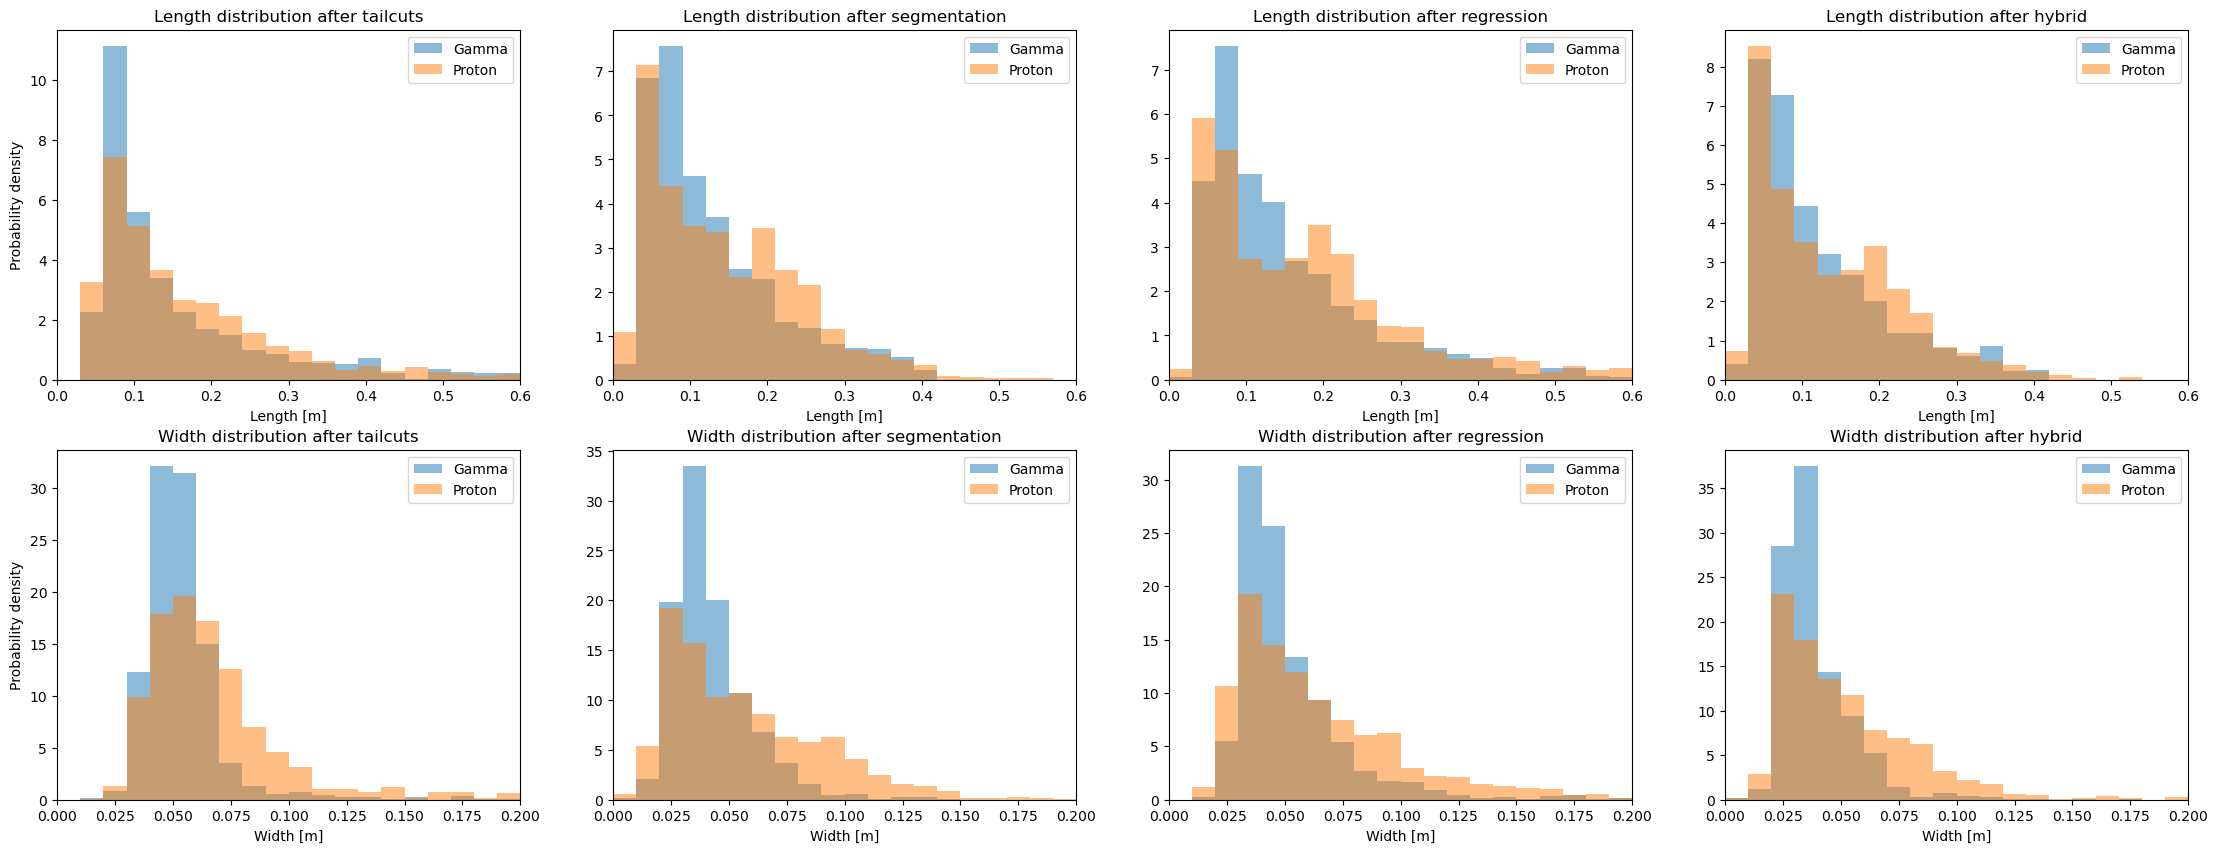

In [123]:
fig_sep, axs = plt.subplots(2, 4, figsize=(27.5,10))

axs[0,0].hist(length_tailcuts, bins=20, range=(0,0.6), alpha=0.5, density=True, label='Gamma')
axs[0,0].hist(length_tailcuts_p, bins=20, range=(0,0.6), alpha=0.5, density=True, label='Proton')
axs[0,0].set_xlabel("Length [m]")
axs[0,0].set_ylabel("Probability density")
axs[0,0].legend()
axs[0,0].set_title("Length distribution after tailcuts")
axs[0,0].set_xlim(0,0.6)

axs[0,1].hist(length_seg, bins=20, range=(0,0.6), density=True, alpha=0.5, label='Gamma')
axs[0,1].hist(length_seg_p, bins=20, range=(0,0.6), density=True, alpha=0.5, label='Proton')
axs[0,1].legend()
axs[0,1].set_xlabel("Length [m]")
axs[0,1].set_title("Length distribution after segmentation")
axs[0,1].set_xlim(0,0.6)

axs[0,2].hist(length_reg, bins=20, range=(0,0.6), density=True, alpha=0.5, label='Gamma')
axs[0,2].hist(length_reg_p, bins=20, range=(0,0.6), density=True, alpha=0.5, label='Proton')
axs[0,2].legend()
axs[0,2].set_xlabel("Length [m]")
axs[0,2].set_title("Length distribution after regression")
axs[0,2].set_xlim(0,0.6)

axs[0,3].hist(length_hybrid, bins=20, range=(0,0.6), density=True, alpha=0.5, label='Gamma')
axs[0,3].hist(length_hybrid_p, bins=20, range=(0,0.6), density=True, alpha=0.5, label='Proton')
axs[0,3].legend()
axs[0,3].set_xlabel("Length [m]")
axs[0,3].set_title("Length distribution after hybrid")
axs[0,3].set_xlim(0,0.6)


axs[1,0].hist(width_tailcuts, bins=20, range=(0,0.2), alpha=0.5, density=True, label='Gamma')
axs[1,0].hist(width_tailcuts_p, bins=20, range=(0,0.2), alpha=0.5, density=True, label='Proton')
axs[1,0].set_xlabel("Width [m]")
axs[1,0].set_ylabel("Probability density")
axs[1,0].legend()
axs[1,0].set_title("Width distribution after tailcuts")
axs[1,0].set_xlim(0, 0.2)

axs[1,1].hist(width_seg, bins=20, range=(0,0.2), density=True, alpha=0.5, label='Gamma')
axs[1,1].hist(width_seg_p, bins=20, range=(0,0.2), density=True, alpha=0.5, label='Proton')
axs[1,1].legend()
axs[1,1].set_xlabel("Width [m]")
axs[1,1].set_title("Width distribution after segmentation")
axs[1,1].set_xlim(0, 0.2)

axs[1,2].hist(width_reg, bins=20, range=(0,0.2), density=True, alpha=0.5, label='Gamma')
axs[1,2].hist(width_reg_p, bins=20, range=(0,0.2), density=True, alpha=0.5, label='Proton')
axs[1,2].legend()
axs[1,2].set_xlabel("Width [m]")
axs[1,2].set_title("Width distribution after regression")
axs[1,2].set_xlim(0, 0.2)

axs[1,3].hist(width_hybrid, bins=20, range=(0,0.2), density=True, alpha=0.5, label='Gamma')
axs[1,3].hist(width_hybrid_p, bins=20, range=(0,0.2), density=True, alpha=0.5, label='Proton')
axs[1,3].legend()
axs[1,3].set_xlabel("Width [m]")
axs[1,3].set_title("Width distribution after hybrid")
axs[1,3].set_xlim(0, 0.2)

plt.show()
fig_sep.savefig("images/Seperation.pdf")